##### Sources for certain modules used in this notebook
-  https://devmount.github.io/GermanWordEmbeddings/
-  http://brandonrose.org/clustering

In [1]:
# Keeping all the imports in one place
# -*- coding: utf-8 -*-
import numpy as np
import base64
import pandas as pd
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib import pyplot as plt
get_ipython().magic(u'matplotlib inline')
from gensim import corpora, models, similarities
import random
from collections import Counter
from __future__ import division
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('german')
#some ipython magic to show the matplotlib plots inline
%matplotlib inline
import gensim
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os
import tensorflow as tf
import numpy as np
from tensorflow.contrib.tensorboard.plugins import projector
from tqdm import tqdm
from gensim.models import KeyedVectors
from time import time
from sklearn.metrics.pairwise import cosine_similarity
from random import randint

import gensim
import os
from gensim.models.word2vec import LineSentence
from gensim.models.fasttext import FastText as FT_gensim
# ENABLE "logging" only when required for inspection and analysis. WMD dist_wmd produces a ton of logs which makes notebook heavy. 
# import logging
# logging.root.handlers = []  # Jupyter messes up logging so needs a reset
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

print "All the imports worked nicely."

/home/D072852/anaconda/envs/py27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



All the imports worked nicely.


In [2]:
# loading pre-trained Deutsche word embeddings from different sources.
# SOURCES:
# Model01 Fb fasttext : pre-trained word vectors, trained on Wikipedia using fastText. These vectors in dimension 300 
# were obtained using the skip-gram model described in Bojanowski et al. (2016) with default parameters.
# # https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md
# #%time model01 = gensim.models.KeyedVectors.load_word2vec_format("wiki.de.vec", binary=False)
%time model01 = FT_gensim.load_fasttext_format('wiki.de.bin', encoding = 'utf8')

# Model: https://devmount.github.io/GermanWordEmbeddings/
%time model = gensim.models.KeyedVectors.load_word2vec_format("german.model", binary=True)

# https://github.com/Kyubyong/wordvectors - NO
#  Model02 : GER64 embeddings; https://github.com/glample/tagger ; https://drive.google.com/open?id=0B23ji47zTOQNdGdqTkk5QWRTZkU
%time model02 = gensim.models.KeyedVectors.load_word2vec_format("GER64", binary=False)

# Model04 : Actual fasttext with 2 mil vocab. https://github.com/facebookresearch/fastText/blob/master/docs/crawl-vectors.md 
%time model03 = FT_gensim.load_fasttext_format('cc.de.300.bin', encoding = 'utf8')


CPU times: user 5min 29s, sys: 7.03 s, total: 5min 36s
Wall time: 5min 45s
CPU times: user 9.41 s, sys: 872 ms, total: 10.3 s
Wall time: 10.3 s
CPU times: user 1min 59s, sys: 3.18 s, total: 2min 2s
Wall time: 2min 2s
CPU times: user 1min 51s, sys: 6.12 s, total: 1min 58s
Wall time: 2min 4s


In [45]:
# ------------------EVALUATING different word embeddings ------------------------------------------------------------------
# Checking the vocabulary size for different embeddings
# print "Size of vocabulary in model01 is %d" % len(model01.vocab)
print model01
print "Size of vocabulary in model02 is %d" % len(model02.vocab)
print "Size of vocabulary in model is %d" % len(model.vocab)
# print "Size of vocabulary in model03 is %d" % len(model03.wv.vocab)
print model03

model_wordList = model.index2word
print type(model_wordList), len(model_wordList)
print "First 50 words in Model vocabulary are: ",  ', '.join(model_wordList[:50])
# model.vocab gives you a dictionary sort of embedding_index_de
# print type(word_vectors.vocab)
# fasttext_wordList = word_vectors.index2word

# fasttext_wordList = model01.index2word
# print type(fasttext_wordList), len(fasttext_wordList)
# print "First 50 words in model01 vocabulary are: ",  ', '.join(fasttext_wordList[:50])

ger64_wordList = model02.index2word
print type(ger64_wordList), len(ger64_wordList)
print "First 50 words in model02 vocabulary are: ",  ', '.join(ger64_wordList[:50])

# model03_wordList = model03.index2word
# print type(model03_wordList), len(model03_wordList)
# print "First 50 words in model02 vocabulary are: ",  ', '.join(model03_wordList[:50])

FastText(vocab=2275233, size=300, alpha=0.025)
Size of vocabulary in model02 is 2001952
Size of vocabulary in model is 608130
FastText(vocab=2000000, size=300, alpha=0.025)
<type 'list'> 608130
First 50 words in Model vocabulary are:  Die, fuer, wurde, Der, dass, Das, ueber, In, Im, wurden, Er, Sie, Jahr, mehr, zwei, Es, Nach, sowie, ab, Jahren, Jahre, sei, Am, beim, drei, seit, koennen, schon, Euro, Stadt, Mit, ersten, Ein, Auch, gibt, etwa, bereits, jedoch, Zeit, immer, Uhr, Als, Bei, 1, Ende, heute, Fuer, sagte, Von, konnte
<type 'list'> 2001952
First 50 words in model02 vocabulary are:  </s>, ., ,, der, die, und, in, '', den, ``, :, mit, das, von, zu, -, im, auf, sich, ist, für, Die, dem, ein, nicht, -RRB-, -LRB-, des, es, eine, auch, an, am, aus, als, bei, hat, Der, dass, er, nach, sie, werden, um, Das, war, noch, sind, einem, wird


In [6]:
# --------------------------------------------------------------------------------------------
# ----Beginning with data processing and Thalia Bookstore data specific implementations-------
# ---------------------------------------------------------------------------------------------
# function taking data frame as input preprocess and return another data frame
def dataPreprocess(train) :
    train = train.iloc[:, :-1]
    train.drop(train.columns[0], axis=1, inplace=True)
    print("Number of rows, columns in train dataset : ",train.shape)
    print train.columns
    print train.dtypes
    train.head(2)
    print "Before removing the duplicates\n", train['ADDITIONALTEXT'].describe()
    # dropping the rows with duplicate values in Additional text field -
    train.drop_duplicates(subset='ADDITIONALTEXT', keep="first", inplace=True)
    print "AFTER removing the duplicates\n", train['ADDITIONALTEXT'].describe()
    train.head(2)
    return train

# trying some plotting of data wrt THEMES
def dataVisualise(train) :
    import matplotlib as mpl
    # Just making the plots look better
    mpl.style.use('ggplot')
    mpl.rcParams['figure.figsize'] = (8,6)
    mpl.rcParams['font.size'] = 16
    print "CHECKING for themes now\n", train['THEME'].describe()
    # trying to filter out the long tail and keep only themes with count more than 3
    counts = train['THEME'].value_counts()
    counts1 =  counts[counts >= 2]
    print "DISTRIBUTION of THEMES:"
    print counts1
    plot_data_theme = train[train['THEME'].isin(counts[counts >= 3].index)]
    plot_data_theme['THEME'].value_counts().plot.bar(y='THEME', figsize=(15,10))

    print "CHECKING for keywords now\n", train['SCHLAGWORT'].describe()
    counts = train['SCHLAGWORT'].value_counts()
    counts2 = counts[counts >= 2]
    print "DISTRIBUTION of Schlagworts:"
    print counts2
#     plot_data_schlagwort = train[train['SCHLAGWORT'].isin(counts[counts >= 4].index)]
#     plot_data_schlagwort['SCHLAGWORT'].value_counts().plot.bar(figsize=(25,10))

    # We can see there are only two categories - Subject and Main Subject.
    print "CHECKING for categories now\n", train['CATEGORY'].describe()

# Exploring the data distribution in our train and test set
# trying to filter out the long tail and keep only themes/other attributes with count more 
# than "threshold" value provided
def data_explore(dataFrame, attribute, threshold):
    counts = dataFrame[attribute].value_counts()
    counts1 =  counts[counts >= 1]
    print "--------DISTRIBUTION of %s in data is:---------" %(attribute)
    print counts1
    plot_data_theme = dataFrame[dataFrame[attribute].isin(counts[counts >= threshold].index)]
    ax = plot_data_theme[attribute].value_counts().plot.bar(y=attribute, figsize=(15,15))
    plot_name = '/home/D072852/ThemeDist' +  '.eps'
#     print plot_name
    ax.figure.savefig(plot_name, format='eps', dpi=1000)
# function to prune the data based on the threshold occurence of number of documents in a specific
# Theme/other attribute    
def data_prune(dataFrame, attribute, threshold):
    counts = dataFrame[attribute].value_counts()
    print "-------DISTRIBUTION of %s in data before Pruning is:--------" %(attribute)
    counts1 =  counts[counts >= 1]
    print counts1
    print "--------DISTRIBUTION of %s in data AFTER Pruning is:---------" %(attribute)
    counts2 = counts[counts >= threshold]
    print counts2
    return dataFrame[dataFrame[attribute].isin(counts[counts >= threshold].index)]

CPU times: user 51.9 s, sys: 5.31 s, total: 57.2 s
Wall time: 57.2 s
('Number of rows, columns in train dataset : ', (4950249, 11))
Index([u'MATNR', u'ISMTITLE', u'ARTIDENTNO', u'ADDITIONALTEXT', u'RATING',
       u'RATINGTITEL', u'RATINGTEXT', u'RATEDAT', u'SCHLAGWORT', u'CATEGORY',
       u'THEME'],
      dtype='object')
MATNR             object
ISMTITLE          object
ARTIDENTNO         int64
ADDITIONALTEXT    object
RATING             int64
RATINGTITEL       object
RATINGTEXT        object
RATEDAT           object
SCHLAGWORT        object
CATEGORY          object
THEME             object
dtype: object
Before removing the duplicates
count                                               4950249
unique                                                26575
top       Der umstrittene Detective William Oliver Layto...
freq                                                  35640
Name: ADDITIONALTEXT, dtype: object
AFTER removing the duplicates
count                                            

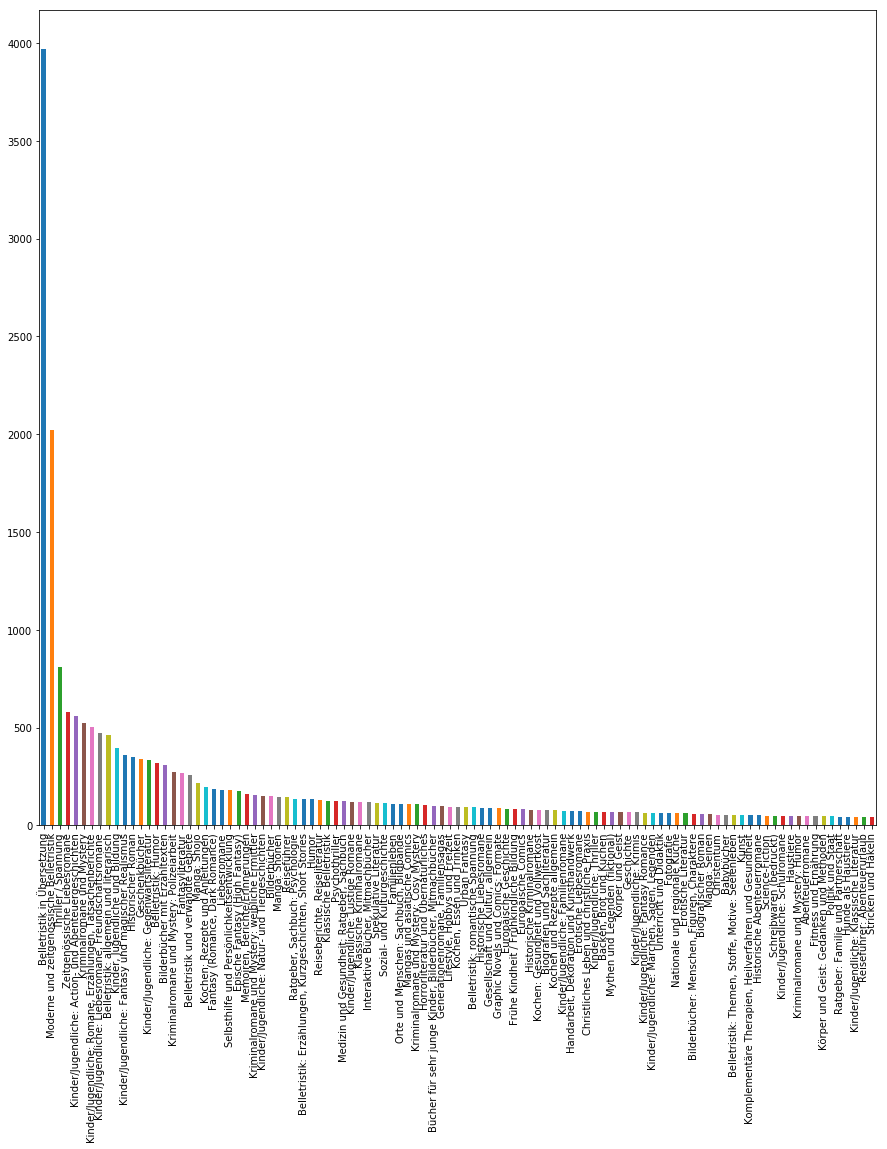

In [7]:
# taking data input and processing, reading first nrows(million here) ONLY
%time train = pd.read_csv("/home/D072852/Thalia_data/thalia_new.csv", sep='|', nrows=4950250)
# %time train = pd.read_csv("/home/D072852/Thalia_data/thalia_new.csv", sep='|', nrows=5)
train.rename(columns={'TO_NVARCHAR(MATNR)':'MATNR', 'TO_NVARCHAR(ISMTITLE)':'ISMTITLE', 'TO_NVARCHAR(ARTIDENTNO)':'ARTIDENTNO',
                          'TO_NVARCHAR(ADDITIONALTEXT)':'ADDITIONALTEXT', 'TO_NVARCHAR(RATING)':'RATING','TO_NVARCHAR(RATINGTITEL)':'RATINGTITEL',
                          'TO_NVARCHAR(RATINGTEXT)':'RATINGTEXT','TO_NVARCHAR(RATEDAT)':'RATEDAT',
                          'TO_NVARCHAR(SCHLAGWORT)':'SCHLAGWORT',
                          'TO_NVARCHAR(CATEGORY)':'CATEGORY', 'TO_NVARCHAR(THEME)':'THEME'}, inplace=True)
train = dataPreprocess(train)
# trying some plotting of data wrt THEMES for first million records
# train.to_csv("/home/D072852/sample_data_csv.csv", sep='\t', encoding='utf-8')
data_explore(train, "THEME", 40)
print "----------------------------------------------------------------"

In [152]:
# data_explore(train, "THEME", 200)

----------------------------------------------------------------
CHECKING for themes now
count                           26575
unique                           1159
top       Belletristik in Übersetzung
freq                             3971
Name: THEME, dtype: object
DISTRIBUTION of THEMES:
Belletristik in Übersetzung                                                                       3971
Moderne und zeitgenössische Belletristik                                                          2019
Thriller / Spannung                                                                                808
Zeitgenössische Liebesromane                                                                       578
Kinder/Jugendliche: Action- und Abenteuergeschichten                                               558
Kriminalromane und Mystery                                                                         523
Kinder/Jugendliche: Romane, Erzählungen, Tatsachenberichte                                

,MATNR,ISMTITLE,ARTIDENTNO,ADDITIONALTEXT,RATING,RATINGTITEL,RATINGTEXT,RATEDAT,SCHLAGWORT,CATEGORY,THEME
4948985,A1009109015,Sommerwogen,18685761,Die literarische Sensation: Der zärtliche Mark...,50,Mark Twain ganz privat,"Da Mark Twain häufig unterwegs war, überbrückt...",29.03.10 20:15,"Twain, Mark",subject,Literaturwissenschaft: 1800 bis 1900
4949609,A1021306244,Stasi konkret,31241783,<br> <p>Eine lückenlose Überwachung...,10,mediengerechte Fleißarbeit,Die vielen Details sind fleißig zusammengetrag...,20.03.13 12:22,Politik,subject,Europäische Geschichte
4949744,A1001098641,Willkommen neue Träume,15493820,Von mitreißender Vielfalt und erzählerischer K...,40,Wunderbar!,Lange habe ich nicht mehr einen so vielseitige...,29.03.10 16:51,Roman,mainsubject,Moderne und zeitgenössische Belletristik
4949754,A1014179985,Sherlock Holmes und das sprechende Pferd,24065505,Sherlock Holmes hat Langeweile: Nach seiner Rü...,30,Ein tierischer Fall,"In der Baker Street 221b herrscht Aufruhr, den...",26.09.12 16:06,Fester Einband,subject,"Graphic Novels, Comics, Cartoons"
4949909,A1017405676,Ein Weihnachtsfest für kleine Engel,29095140,Noch 24 Tage bis Weihnachten &amp;#8211; und d...,50,Zuckersüßer Adventskalender,Mit richtig klasse Bildern und superschönen kl...,29.10.11 09:51,Rentier,mainsubject,Bilderbücher mit Erzähltexten
4949923,A1000862382,Schizophrenie - ein Denkausbruch mit Folgen,13958443,"Erklärung, wie es zur Schizophrenie kommt. Nic...",50,Schon lange...,Ich habe selbst die Erfahrung einer Paranoiden...,05.12.07 22:15,Ich-Schwäche,mainsubject,Klinische und Innere Medizin
4949928,A1040433299,Mein Bruder Che,46100893,Als die Guevaras aus den Schlagzeilen der Tage...,50,"Eine Lektüre, die sich lohnt!",Eine objektive Darstellung darf man nicht erwa...,05.07.17 13:30,Fester Einband,mainsubject,Politik und Staat
4950081,A1000431193,Musik,3078713,<br> <p>In zahlreichen Betrachtunge...,50,"Hermann Hesse, Musik",Für Hermann Hesse war Musik seit seiner Kindhe...,01.02.11 10:40,Musik,subject,Musikwissenschaft und Musiktheorie
4950153,A1045219865,Backen mit Christina,64219372,"BROT, GEBÄCK UND SÜSSE KÖSTLICHKEITEN IN WINDE...",50,Kaufempfehlung,"Das Cover, sowie die Umschlaggestaltung ist wu...",01.09.17 16:08,Fester Einband,subject,Schnelle Küche
4950201,A1035055535,Im frühen Morgenlicht,41089435,"Morgan Spencer, der erfolgreich große Firmen s...",50,Nächstenliebe und Vergebung,"Ein Buch, das durch seine liebevollen Menschen...",12.05.15 09:39,Kartonierter Einband (Kt),subject,Liebesromane


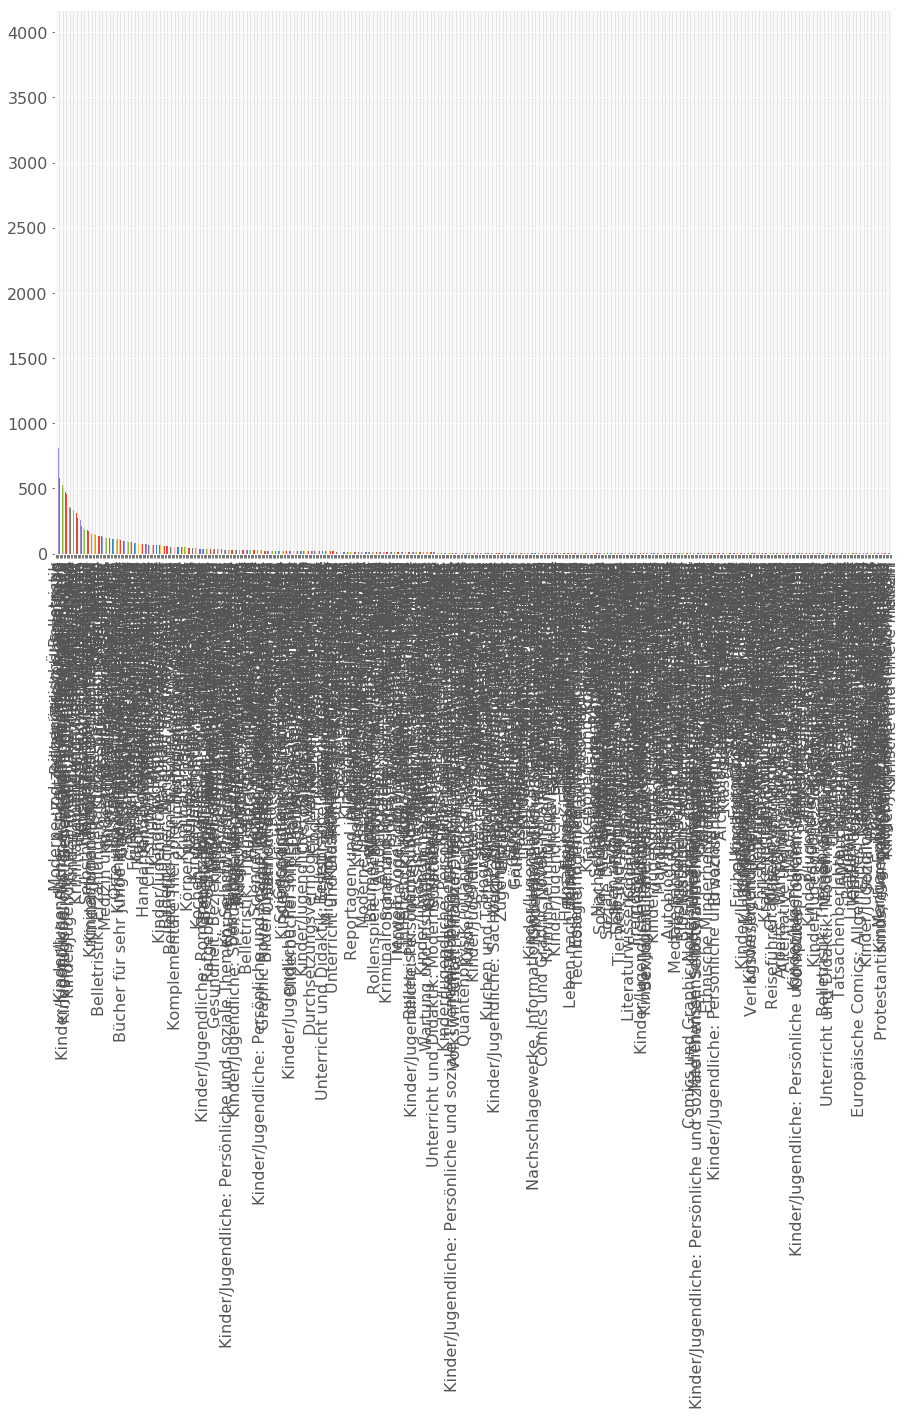

In [8]:
# Now pruning the data to keep only top 10 THEMES for further clustering evaluation
# train = data_prune(train, 'THEME', 120)
print "----------------------------------------------------------------"
# keeping only values relating to specific "un-related" THEMES
# train = train.loc[train['THEME'].isin(['Kochen: Rezepte und Anleitungen','Humor','Psychothriller'])]
# train = train.loc[train['THEME'].isin(['Selbsthilfe und Persönlichkeitsentwicklung','Bilderbücher mit Erzähltexten','Kochen: Rezepte und Anleitungen'])]

# trying some plotting of data wrt THEMES
dataVisualise(train)
work_df = train
train_text = train['ADDITIONALTEXT'].tolist()
train_id = train['MATNR'].tolist()
train_theme = train['THEME'].tolist()
train_schlagwort = train['SCHLAGWORT'].tolist()
train_title = train['ISMTITLE'].tolist()

# some sanity checks for data
print len(train_id)
print len(train_text)

total_len = 0
# calculating the average text lenght in training corpus
for s in train_text:
    total_len = total_len + len(s.split())
average_text_len = total_len/len(train_text)

print "Average length of the documents in training corpus is", average_text_len

train.head()
train.tail(10)

In [9]:
# Actual data preprocessing starts from here - 

# load nltk's SnowballStemmer as variabled 'stemmer'
# NOTE - this stemmer works by brute force chunking of fthe "en"/"es" from word endings plus it removes 1. casing information 
# 2. Umlaut and special character information. On the whole lot of information loss. Advice to use SPACY lemmatizer.
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("german")

# Lemmatizer does NOT work for Deutsche language 
# from nltk.stem import WordNetLemmatizer
# wnl = WordNetLemmatizer()

# generating list of stop_words with title case to be removed from text as well
stop_words = stopwords.words('german')
stop_words_caps = [word.title() for word in stop_words]
stop_words.extend(stop_words_caps)

# //alle
# //alle bände
# //textauszug
# /em
# /em /strong
# /li
# /li /ul
# /strong
# /strong br/
# /strong br/ br/
# /strong strong
# /ul amaray/dvd \r/n
# extra missing (variations of) stop words that pop up in data
extra_stop_words = ["dass","amp", "Und", "her", "Her","\r/n", "/br", "br/", "//alle", "/em", "/strong", "/li", "/ul", "//textauszug", "\tmit", "amaray/dvd",
                    "\r/n"]
extra_stop_words1 = ["dass","amp", "apos", "Und", "her", "Her","\r/n", "/br", "br/", "//alle", "/em", "/strong", "/li", "/ul", "//textauszug"]
extra_stop_words2 = ["'das","'die","'der","'eine","'ein","'ich",'\r/n', '/br', 'br/', '//alle', '/em', '/strong', '/li', '/ul', '//textauszug']
extra_stop_words3 = [u'.0001pt', u'.die', u'0cm', u'10h', u'11h', u'12h',
                     u'16j\xe4hrige', u'18h', u'19h', u'22h', u'32h', u'3kg', u'3sat',u'5.4pt', u'5th', u'\\r/n',
                     u'\\r/n\\r/n', u'\\r/n\\r/nder', u'\\r/n\\r/ndie', u'\\r/nder', u'\\r/ndie', u'\\r/nes', u'\\tder',
                     u'\\tdie', u'\\tein', u'\\tmit']
stop_words.extend(extra_stop_words)
stop_words.extend(extra_stop_words1)
stop_words.extend(extra_stop_words2)
stop_words.extend(extra_stop_words3)

stop_words.extend(extra_stop_words)
# print stop_words, len(stop_words)

# Here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token) and len(token) > 2:
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation) 
    # and words whose length is less than 2 characters - removes <br/a> formating from data 
    for token in tokens:
        for splitToken in re.split('-', token):
            if re.search('[a-zA-Z]', splitToken) and len(splitToken) > 2:
                filtered_tokens.append(splitToken)
    return filtered_tokens

def tokenize_and_stopWordsRemoval(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation) and words whose length is less than 2 characters - removes <br/a> formating from data 
    for token in tokens:
        if re.search('[a-zA-Z]', token) and len(token) > 2 and token not in stop_words :
            filtered_tokens.append(token)
    return filtered_tokens

#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag
def strip_proppers_POS(text):
    tagged = pos_tag(text) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

print "BEFORE preprocess text looks like - "
print train_text[2]

#tokenize
%time tokenized_text = [tokenize_only(text.decode('utf-8')) for text in train_text]
%time tokenizedStemmed_text = [tokenize_and_stem(text.decode('utf-8')) for text in train_text]

print "done with tokenisation","After tokenisation text is -"
# print tokenized_text[0]
for word in tokenized_text[2]:
    print word,    
    
#remove stop words
%time texts = [[word for word in text if word not in stop_words] for text in tokenized_text]
print "done with stop word removal","After stop word removal text is -"
for word in texts[2]:
    print word,

BEFORE preprocess text looks like - 
<p>Hana verliebt sich in einen mysteriösen jungen Mann, doch dieser hat ein Geheimnis: Er stammt vom Geschlecht der japanischen Wölfen ab, die schon seit über hundert Jahren ausgestorbenen sind und ist daher halb Mensch und halb Wolf. Hana wird schwanger und bekommt bald darauf ihr erstes Kind, Yuki. Als im Jahr darauf Ame geboren wird, stirbt der Vater, als er in Wolfsgestalt durch die Stadt läuft. Von nun an wachsen die beiden Kinder bei ihrer jungen Mutter auf. Doch schon bald kommt es zu Schwierigkeiten, da sich die Kinder immer wieder in Wölfchen verwandeln. Und Hana muss sich überlegen, wie sie ihre kleine Familie beschützen kann.</p>
CPU times: user 48.1 s, sys: 344 ms, total: 48.4 s
Wall time: 48.4 s
CPU times: user 1min 2s, sys: 284 ms, total: 1min 3s
Wall time: 1min 3s
done with tokenisation After tokenisation text is -
Hana verliebt sich einen mysteriösen jungen Mann doch dieser hat ein Geheimnis stammt vom Geschlecht der japanischen Wölf

In [8]:
print min(texts, key=len)  # prints "Keith"
print len(max(texts, key=len))

[u'Lesen']
378


In [11]:
texts_unicode = []
for i in range(len(texts)):
    texts_unicode.append(" ".join(texts[i]))

texts_str = []
for i in range(len(texts_unicode)):
#     texts[i] = texts[i].encode('utf-8')
    texts_str.append(texts_unicode[i].encode('utf-8'))
print type(texts_str[0])

texts_lower = [[j.lower() for j in i] for i in texts]
# sanity check
print texts_unicode[0]
print texts_str[0]

<type 'str'>
PECUNIA Versicherungs Ratgeber Dirk Magnutzki Sicher vorgesorgt EINFACH VERSTÄNDLICH NACHVOLLZIEHBAR versteht wirklich Vollkommen neu innovativ Deutschlands Versicherungs Ratgeber Videobeiträgen Codes besseren Verständnis hinterlegt Schnell einfach verständlich setzt Video Buch neue Maßstäbe Endlich Buch Lesertypen ganz gleich Allesleser Nachschlager Querleser kommt Kosten. Schluss Chaos Sachen Versicherungen rät Verbraucher verunsichert Themen Vorsorge Versicherungsschutz schmücken Hass Ecke Aktenschrank Lebens Rentenversicherungen gut schlecht hoch gepriesene staatliche Förderung privaten Altersvorsorge Flop sinnvoll besten krankenversichern Sachversicherungen braucht eigentlich Gut Diplom Versicherungs Fachexperte Dirk Magnutzki Sachverständiger Versicherungswesen Gerichtsgutachter Experte Sendereihe Pecunia seit Jahren Versicherungsbranche tätig unabhängiger Versicherungsmakler wurde mehrfach ausgezeichnet bester Makler NRW Deutschland. erläutert verständlichen nachvol

### AutoEncoder code starts here:

In [11]:
import pickle
import itertools
import numpy as np
from scipy import spatial
from scipy.stats import norm
import nltk.data
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.tokenize import sent_tokenize
from gensim.models import KeyedVectors
from keras.layers import Input, Dense, Lambda, Layer
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras import backend as K
from keras import metrics

def vectorize_sentences(sentences):
    vectorized = []
    for sentence in sentences:
        byword = sentence.split()
        concat_vector = []
        for word in byword:
            try:
                concat_vector.append(model01[word])
            except:
                pass
        vectorized.append(concat_vector)
    return vectorized

data_concat = []
vec_texts = vectorize_sentences(train_text)
# wikidata = [x for x in wiki_tokens if len(x) == 10]
# print vec_texts[:5]
# print len(max(vec_texts, key=len))

# for x in vec_texts:
#     if (len(x) <= 100):
#         data_concat.append(list(itertools.chain.from_iterable(x)))

for x in vec_texts:
    data_concat.append(list(itertools.chain.from_iterable(x)))

Using TensorFlow backend.
/home/D072852/anaconda/envs/py27/lib/python2.7/site-packages/gensim/models/keyedvectors.py:265: UnicodeWarning:

Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal



In [10]:
print len(data_concat)
# contents on data_concat[0] the word vector values of all the words in a sentence in seq order. 
# print data_concat[0]
print len(max(data_concat, key=len))

# code to know the average len of items in data_concat
len_sum = 0
len_list = []
for d in data_concat:
    len_sum += len(d)
    len_list.append(len(d))

avg_len = len_sum/len(data_concat)
print avg_len
len_counter = Counter(len_list)
print len_counter.most_common(10)

# zero padding the input sequences to average length here = 16000, and trimming input of len more than 16000
# a += [''] * (N - len(a))
data_concat_fixedlen = []
for a in data_concat:
    if (len(a) < 16000):
        a += ['0'] * (16000 - len(a))
        data_concat_fixedlen.append(a)
    else:
        data_concat_fixedlen.append(a[:16000])

26575
123900
17732.0489182
[(15600, 515), (14700, 510), (13800, 509), (14100, 507), (14400, 500), (16800, 494), (16200, 493), (15900, 490), (12000, 478), (15300, 477)]


In [ ]:
# # It's important to shuffle the text vectors before splitting them into test and train samples.
data_array = np.array(data_concat_fixedlen)
np.random.shuffle(data_array)

# train = data_array[:19500]
# test = data_array[19500:24354]

train = data_array[:21000]
test = data_array[21000:26575]

In [16]:
print len(train), len(test)


# print len(train[12])
print len(data_concat_fixedlen[0])
print len(max(data_concat_fixedlen, key=len))
print len(max(test, key=len))
print len(max(train, key=len))

print len(data_concat_fixedlen)

21000 5575
16000
16000
16000
16000
26575


In [67]:
from keras.layers import Input, Dense, Lambda, Layer
# batch_size = 50
# original_dim = 30000
# latent_dim = 1000
# intermediate_dim = 1200
# epochs = 2
# epsilon_std = 1.0
train_new = train
INPUT_SIZE = 16000
ENCODING_SIZE = 1000
 
input_img = Input(shape=(INPUT_SIZE,))

encoded = Dense(ENCODING_SIZE, activation='relu')(input_img)
decoded = Dense(INPUT_SIZE, activation='relu')(encoded)
autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(train_new, train_new, epochs=28, batch_size=256, shuffle=True, validation_data=(test, test))

Train on 19500 samples, validate on 4854 samples
Epoch 1/10
19500/19500 [==============================] - 365s 19ms/step - loss: 0.0257 - val_loss: 0.0250
Epoch 2/10
19500/19500 [==============================] - 203s 10ms/step - loss: 0.0251 - val_loss: 0.0248
Epoch 3/10
19500/19500 [==============================] - 206s 11ms/step - loss: 0.0248 - val_loss: 0.0246
Epoch 4/10
19500/19500 [==============================] - 206s 11ms/step - loss: 0.0245 - val_loss: 0.0244
Epoch 5/10
19500/19500 [==============================] - 206s 11ms/step - loss: 0.0243 - val_loss: 0.0242
Epoch 6/10
19500/19500 [==============================] - 206s 11ms/step - loss: 0.0242 - val_loss: 0.0241
Epoch 7/10
19500/19500 [==============================] - 205s 11ms/step - loss: 0.0240 - val_loss: 0.0240
Epoch 8/10
19500/19500 [==============================] - 205s 11ms/step - loss: 0.0239 - val_loss: 0.0240
Epoch 9/10
19500/19500 [==============================] - 206s 11ms/step - loss: 0.0238 - val_l

In [ ]:
from keras.callbacks import History 
history = History()

INPUT_SIZE = 16000
ENCODING_SIZE = 1000

input_img = Input(shape=(INPUT_SIZE,))
encoded = Dense(ENCODING_SIZE, activation='relu')(input_img)
decoded = Dense(INPUT_SIZE, activation='relu')(encoded)
autoencoder01 = Model(input_img, decoded)

autoencoder01.compile(optimizer='adam', loss='mean_squared_error')
history = autoencoder01.fit(train, train, epochs=28, batch_size=256, shuffle=True, validation_data=(test, test))

Train on 21000 samples, validate on 5575 samples
Epoch 1/28
21000/21000 [==============================] - 239s 11ms/step - loss: 0.0260 - val_loss: 0.0257
Epoch 2/28
21000/21000 [==============================] - 241s 11ms/step - loss: 0.0254 - val_loss: 0.0255
Epoch 3/28
21000/21000 [==============================] - 242s 12ms/step - loss: 0.0252 - val_loss: 0.0252
Epoch 4/28
21000/21000 [==============================] - 242s 12ms/step - loss: 0.0249 - val_loss: 0.0251
Epoch 5/28
21000/21000 [==============================] - 242s 12ms/step - loss: 0.0248 - val_loss: 0.0250
Epoch 6/28
21000/21000 [==============================] - 243s 12ms/step - loss: 0.0247 - val_loss: 0.0249
Epoch 7/28
21000/21000 [==============================] - 242s 12ms/step - loss: 0.0246 - val_loss: 0.0249
Epoch 8/28
21000/21000 [==============================] - 243s 12ms/step - loss: 0.0245 - val_loss: 0.0248
Epoch 9/28
21000/21000 [==============================] - 241s 11ms/step - loss: 0.0245 - val_l

In [ ]:
print(history.history['val_loss'])
# autoencoder01.summary()
# pred = autoencoder01.predict(test)
# pred.shape
# this model maps an input to its encoded representation
data_concat_fixedlen_array = np.array(data_concat_fixedlen)
encoder = Model(input_img, encoded)
pred  = encoder.predict(data_concat_fixedlen_array)
pred.shape

In [22]:
sim = cosine_similarity((pred[0]).reshape(1, -1), (pred[1]).reshape(1, -1))[0][0]
print sim
dist_dracula4213 = []
for i in range(26575):
    sim = cosine_similarity((pred[i]).reshape(1, -1), (pred[4213]).reshape(1, -1))[0][0]
    dist_dracula4213.append(1-sim)

print len(dist_dracula4213)
sorted_dist_4213 = np.argsort(dist_dracula4213)

# print sorted_dist_4213[:20]
# for d in sorted_dist_4213[:5]:
#     print train_title[d]
#     print train_text[d]
#     print

0.61000943
26575


CBOW methods from here onwards -
RESULTS Generation for final document.

In [12]:
for i in range(0,train.shape[0]):
    if "Selection" in train_title[i] or "Panem" in train_title[i]:
        print i," ", train.iloc[i]['MATNR'], " ", train_title[i]

3493   A1035505235   Selection 04. Die Kronprinzessin
3510   A1036106431   Selection Storys. Herz oder Krone
3711   A1030404279   Selection 02. Die Elite
3732   A1033810461   Selection Storys. Liebe oder Pflicht
3808   A1033737713   Selection 01
3824   A1036063248   Die Tribute von Panem 3. Flammender Zorn (2 MP3 CDs)
3825   A1036063252   Die Tribute von Panem 1-3 Gesamtausgabe (6 MP3 CDs)
4143   A1036124602   Selection 04. Die Kronprinzessin
4277   A1036124635   Selection Storys. Herz oder Krone
4294   A1033737502   Selection 02. Die Elite
4601   A1038082300   Die Tribute von Panem - 3 Bände im Schuber
10358   A1032584767   Die Tribute von Panem 2. Gefährliche Liebe
10702   A1033869017   Die Tribute von Panem - 3 Bände im Schuber
11506   A1033810453   Selection 01
11706   A1034732534   Selection 02. Die Elite
19315   A1034974500   Selection 03. Der Erwählte
19329   A1033470026   Selection 03. Der Erwählte
19749   A1019803319   Die Tribute von Panem 1. Tödliche Spiele
24036   A10395117

In [98]:
print train_text[19749]
print train_text[3808]

Als Katniss erfährt, dass das Los auf ihre kleine Schwester Prim gefallen ist, zögert sie keinen Moment. Um Prim zu schützen, meldet sie sich an ihrer Stelle für die alljährlich stattfindenden Spiele von Panem &amp;#8211; in dem sicheren Wissen, damit ihr eigenes Todesurteil unterschrieben zu haben. Denn von den 24 Kandidaten darf nur ein Einziger überleben! Zusammen mit Peeta, einem Jungen aus ihrem Distrikt, wird Katniss in die Arena geschickt, um sich dem Kampf zu stellen. Sie beide wissen, dass es nur einen Sieger geben kann. Allerdings scheint das Peeta nicht zu kümmern, denn er rettet Katniss das Leben. Sind seine Gefühle ihr gegenüber vielleicht doch nicht nur gespielt, um das Publikum vor den Bildschirmen für sich einzunehmen? Katniss weiß nicht mehr, was sie glauben darf &amp;#8211; und vor allem nicht, was sie selbst empfindet&amp;#8230;.
<p>35 perfekte Mädchen - und eine von ihnen wird erwählt. Sie wird Prinz Maxon, den Thronfolger des Staates Illeá, heiraten. Für die hübsch

In [13]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.4 , max_features=200000,
                                 min_df=4 , stop_words= stop_words,
                                 use_idf=True, tokenizer=tokenize_only)

%time tfidf_matrix = tfidf_vectorizer.fit_transform(texts_str) #fit the vectorizer to synopses

print(tfidf_matrix.shape)
terms = tfidf_vectorizer.get_feature_names()

from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
dist = 1 - cosine_similarity(tfidf_matrix)

# TFIDF features on the entire corpus
# (26575, 37436)

CPU times: user 21.6 s, sys: 73.2 ms, total: 21.6 s
Wall time: 21.6 s
(26575, 37436)


In [14]:
# print sorted_distances[:10]
feature_names = terms
doc = 10284
feature_index = tfidf_matrix[doc,:].nonzero()[1]
tfidf_scores = zip(feature_index, [tfidf_matrix[doc, x] for x in feature_index])
# sort the scores in descending order

# print (tfidf_scores)
print (tfidf_scores[0])
tfidf_scores_sorted = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
# print (tfidf_scores_sorted)

# for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores_sorted]:
#   print w, s
for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores_sorted]:
    print w,

(27270, 0.08605070953092926)
dracula literarischen stokers abbruch vampirroman stoker bildgewaltig bram originals wegzudenken dämonischen schaurig leseerlebnis qualitäten untoten grafen irischen erschien schönes kino bekanntesten anwalt getan gestalt vampire film figuren literatur besonders kaum entdeckt jahr jedoch heute schnell jungen roman seit welt mehr


In [15]:
# Initializing Count Vectorizer for SIF calculation
from sklearn.feature_extraction.text import CountVectorizer
cvectorizer = CountVectorizer(max_df=0.4 , max_features=200000,
                                 min_df=4 , stop_words= stop_words,
                                tokenizer=tokenize_only)
count_vectorizer_matrix = cvectorizer.fit_transform(texts_str)
print count_vectorizer_matrix.shape
count_vec_terms = cvectorizer.get_feature_names()
print len(count_vec_terms)
print count_vec_terms[:5]

sum_count_vec_terms = count_vectorizer_matrix.toarray().sum(axis=0)
print sum_count_vec_terms.shape
print sum_count_vec_terms[:10]

(26575, 37436)
37436
[u"'normale", u"'times", u'14j\xe4hrige', u'1920er', u'1930er']
(37436,)
[ 4  4  5 22 22  8 24 14 17  4]


In [16]:
def countVectorizerWeights(docIndex, sum_count_vec_terms, count_vec_terms):
    #create another document with tokens arranged in descending order of their tfidf scores
    new_document = {}
    for token in texts[docIndex]:
        if token in count_vec_terms:
            index_token = count_vec_terms.index(token)
            weight = sum_count_vec_terms[index_token]
#             print token
        else:
            weight = texts[docIndex].count(token)
#             print "ELSE block " + token
        new_document.update({token:weight})
    return new_document

# print texts[2]
print(len(texts[10284]))
weights1 = countVectorizerWeights(10284, sum_count_vec_terms, count_vec_terms)
print len(weights1.keys())
for key, value in weights1.items():
    print key, value,

# NOTE - length of token weights returned by countVectorizerWeights() may be less than the original texts
# because the dictionary countVectorizerWeights() returns contains ONLY unique keys which texts might have multple entries for.

46
44
Qualitäten 1 kaum 936 Jahr 1 Vampire 1 'Dracula 1 Gestalt 1 Besonders 1 jungen 1742 Abbruch 1 erschien 76 irischen 63 Stokers 1 Untoten 1 mehr 5472 getan 134 literarischen 86 Anwalt 1 Kino 1 entdeckt 977 Stoker 1 Originals 1 Seit 1 Figuren 1 Literatur 1 schaurig 22 dämonischen 15 Roman 1 Welt 1 heute 1358 genreeigenen 1 bildgewaltig 7 schönes 85 Bram 1 Dracula 2 Leseerlebnis 1 wegzudenken 14 Grafen 1 Unterhaltungsschriftstellers 1 Vampirroman 1 schnell 1362 jedoch 1119 bekanntesten 94 Harker 1 Film 1


In [17]:
def tfIdfSortedText(docIndex, tfidf_matrix, feature_names):
    feature_index = tfidf_matrix[docIndex,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [tfidf_matrix[docIndex, x] for x in feature_index])
    # sort the scores in descending order
    tfidf_scores_sorted = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
    #create another document with tokens arranged in descending order of their tfidf scores
    new_document = []
    for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores_sorted]:
        new_document.append(w)
    return new_document

def tfIdfSortedWeights(docIndex, tfidf_matrix, feature_names):
    feature_index = tfidf_matrix[docIndex,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [tfidf_matrix[docIndex, x] for x in feature_index])
    # sort the scores in descending order
    tfidf_scores_sorted = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
    #create another document with tokens arranged in descending order of their tfidf scores
    new_document = {}
    for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores_sorted]:
        new_document.update({w:s})
    return new_document

# Sanity Checks
# print tfIdfSortedWeights(20, tfidf_matrix, feature_names)
# work_dic1 = tfIdfSortedWeights(0, tfidf_matrix, feature_names)
# print work_dic1
# tokens1 = tfIdfSortedText(0, tfidf_matrix, feature_names)
# print tokens1


# def weighted_average_similarity(sent1, sent2, model, zeroWtDocs, OOV_list): 
#     sent1tfIdfTokens = tfIdfSortedText(sent1, tfidf_matrix, feature_names)
#     sent1weights = tfIdfSortedWeights(sent1, tfidf_matrix, feature_names)
#     sent2tfIdfTokens = tfIdfSortedText(sent2, tfidf_matrix, feature_names)
#     sent2weights = tfIdfSortedWeights(sent2, tfidf_matrix, feature_names)
        
#     weights1 = [sent1weights[token] 
#                 for token in sent1weights.keys() if token in model]
#     weights2 = [sent2weights[token] 
#                 for token in sent2weights.keys() if token in model]
# #     OOV_list = []
# #     OOV_list1 =  [token for token in sent1weights.keys() if token not in model]
# #     OOV_list2 =  [token for token in sent2weights.keys() if token not in model]
#     for token in sent1weights.keys():
#         if token not in model:
#             OOV_list.append(token)
#     for token in sent2weights.keys():
#         if token not in model:
#             OOV_list.append(token)
#     try:
#         embedding1 = np.average([model[token] for token in sent1weights.keys() if token in model], axis=0, weights=weights1).reshape(1, -1)
#     except ZeroDivisionError, e:
#         zeroWtDocs.append(sent1)
#         return 0
#     try:
#         embedding2 = np.average([model[token] for token in sent2weights.keys() if token in model], axis=0, weights=weights2).reshape(1, -1)
#     except ZeroDivisionError, e:
#         zeroWtDocs.append(sent2)
#         return 0
#     sim = cosine_similarity(embedding1, embedding2)[0][0]
# #     print "%s OOV words that came across:" % i,
# #     print (" ").join(token for token in OOV_list)
#     return sim

In [18]:
def run_avg_benchmark(sent1, sent2, model, zeroWtDocs, OOV_list): 

    sent1tfIdfTokens = tfIdfSortedText(sent1, tfidf_matrix, feature_names)
    sent2tfIdfTokens = tfIdfSortedText(sent2, tfidf_matrix, feature_names)
        
    OOV_list1 =  [token for token in sent1tfIdfTokens if token not in model]
    OOV_list2 =  [token for token in sent2tfIdfTokens if token not in model]
    OOV_list.extend(OOV_list1)
    OOV_list.extend(OOV_list2)
    
    try:
        embedding1 = np.average([model[token] for token in sent1tfIdfTokens if token in model], axis=0).reshape(1, -1)
    except ZeroDivisionError, e:
        zeroWtDocs.append(sent1)
        return 0
    try:
        embedding2 = np.average([model[token] for token in sent2tfIdfTokens if token in model], axis=0).reshape(1, -1)
    except ZeroDivisionError, e:
        zeroWtDocs.append(sent2)
        return 0
    try:
        sim = cosine_similarity(embedding1, embedding2)[0][0]
    except ValueError, e:
        zero_wt_docs.append(sent2)
        return 0
    return sim


def run_avg_benchmark_exp(sent1, sent2, model, zeroWtDocs, OOV_dic): 

    sent1tfIdfTokens = tfIdfSortedText(sent1, tfidf_matrix, feature_names)
    sent2tfIdfTokens = tfIdfSortedText(sent2, tfidf_matrix, feature_names)
        
    wordVec1 = []
    wordVec2 = []
    
    model_wordList = model.index2word
    
    for token in sent1tfIdfTokens:
        if token in model:
            wordVec1.append(model[token])
        elif token in OOV_dic.keys():
#             print "%s token OOV, using predefined tag %s" % (token, OOV_dic[token])
            wordVec1.append(model[OOV_dic[token]])
        else:
            random_id = randint(0, len(model_wordList))
            fixed_random_token = model_wordList[random_id]
            OOV_dic.update({token:fixed_random_token})
            wordVec1.append(model[fixed_random_token])
#             print "%s token OOV, CREATING predefined tag %s" % (token, OOV_dic[token])
            
    try:
        embedding1 = np.average(wordVec1, axis=0).reshape(1, -1)
    except ZeroDivisionError, e:
        zeroWtDocs.append(sent1)
        return 0
        
    for token in sent2tfIdfTokens:
        if token in model:
            wordVec2.append(model[token])
        elif token in OOV_dic.keys():
#             print "%s token OOV, using predefined tag %s" % (token, OOV_dic[token])
            wordVec2.append(model[OOV_dic[token]])
        else:
            random_id = randint(0, len(model_wordList))
            fixed_random_token = model_wordList[random_id]
            OOV_dic.update({token:fixed_random_token})
            wordVec2.append(model[fixed_random_token])
#             print "%s token OOV, CREATING predefined tag %s" % (token, OOV_dic[token])
            
    try:
        embedding2 = np.average(wordVec2, axis=0).reshape(1, -1)
    except ZeroDivisionError, e:
        zeroWtDocs.append(sent2)
        return 0
        
    sim = cosine_similarity(embedding1, embedding2)[0][0]
    return sim

def weighted_average_similarity(sent1, sent2, model, zeroWtDocs, OOV_list): 

    sent1weights = tfIdfSortedWeights(sent1, tfidf_matrix, feature_names)
    sent2weights = tfIdfSortedWeights(sent2, tfidf_matrix, feature_names)
        
#     all the tfIDF weights associated with sentence are here, independent of OOV word(s)
    weights1 = [sent1weights[token] 
                for token in sent1weights.keys()]
    weights2 = [sent2weights[token] 
                for token in sent2weights.keys()]
    
    wordVec1 = []
    wordVec2 = []
    for token in sent1weights.keys():
        if token in model:
            wordVec1.append(model[token])
        else:
            OOV_list.append(token)
            wordVec1.append(model['buch'])
            
    try:
        embedding1 = np.average(wordVec1, axis=0, weights=weights1).reshape(1, -1)
    except ZeroDivisionError, e:
        zeroWtDocs.append(sent1)
        return 0
        
    for token in sent2weights.keys():
        if token in model:
            wordVec2.append(model[token])
        else:
            OOV_list.append(token)
            wordVec2.append(model['buch'])
            
    try:
        embedding2 = np.average(wordVec2, axis=0, weights=weights2).reshape(1, -1)
    except ZeroDivisionError, e:
        zeroWtDocs.append(sent2)
        return 0
        
    sim = cosine_similarity(embedding1, embedding2)[0][0]
    return sim

def weighted_average_similarity_exp(sent1, sent2, model, zeroWtDocs, OOV_dic): 

    sent1weights = tfIdfSortedWeights(sent1, tfidf_matrix, feature_names)
    sent2weights = tfIdfSortedWeights(sent2, tfidf_matrix, feature_names)
    model_wordList = model.index2word
        
#     all the tfIDF weights associated with sentence are here, independent of OOV word(s)
    weights1 = [sent1weights[token] 
                for token in sent1weights.keys()]
    weights2 = [sent2weights[token] 
                for token in sent2weights.keys()]
    
    wordVec1 = []
    wordVec2 = []
    for token in sent1weights.keys():
        if token in model:
            wordVec1.append(model[token])
        elif token in OOV_dic.keys():
#             print "%s token OOV, using predefined tag %s" % (token, OOV_dic[token])
            wordVec1.append(model[OOV_dic[token]])
        else:
            random_id = randint(0, len(model_wordList))
            fixed_random_token = model_wordList[random_id]
            OOV_dic.update({token:fixed_random_token})
            wordVec1.append(model[fixed_random_token])
#             print "%s token OOV, CREATING predefined tag %s" % (token, OOV_dic[token])
            
    try:
        embedding1 = np.average(wordVec1, axis=0, weights=weights1).reshape(1,-1)
    except ZeroDivisionError, e:
        zeroWtDocs.append(sent1)
        return 0
        
    for token in sent2weights.keys():
        if token in model:
            wordVec2.append(model[token])
        elif token in OOV_dic.keys():
#             print "%s token OOV, using predefined tag %s" % (token, OOV_dic[token])
            wordVec2.append(model[OOV_dic[token]])
        else:
            random_id = randint(0, len(model_wordList))
            fixed_random_token = model_wordList[random_id]
            OOV_dic.update({token:fixed_random_token})
            wordVec2.append(model[fixed_random_token])
#             print "%s token OOV, CREATING predefined tag %s" % (token, OOV_dic[token])
            
    try:
        embedding2 = np.average(wordVec2, axis=0, weights=weights2).reshape(1,-1)
    except ZeroDivisionError, e:
        zeroWtDocs.append(sent2)
        return 0
        
    sim = cosine_similarity(embedding1, embedding2)[0][0]
    return sim

In [22]:
zero_wt_docs = []
OOV_list = []
OOV_dic_model01 = {}
print weighted_average_similarity(100, 101, model01, zero_wt_docs, OOV_list)
print run_avg_benchmark(100, 101, model01, zero_wt_docs, OOV_list)
# print weighted_average_similarity_exp(100, 101, model01, zero_wt_docs, OOV_dic_model01)
# print run_avg_benchmark_exp(100, 101, model01, zero_wt_docs, OOV_dic_model01)
print zero_wt_docs
print run_sif_benchmark(100, 101, model01, zero_wt_docs, OOV_list)
# print run_sif_benchmark_exp(100, 101, model01, zero_wt_docs, OOV_dic_model01)

0.6609951468657143
0.69295394
[]
0.7073639963385141


/home/D072852/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:94: DeprecationWarning:

Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).

/home/D072852/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:95: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/home/D072852/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:107: DeprecationWarning:

Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).

/home/D072852/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:108: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/home/D072852/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__contains__` (Meth

In [42]:
from sklearn.decomposition import TruncatedSVD
import decimal

vocab_len = 1316

def remove_first_principal_component(X):
    svd = TruncatedSVD(n_components=1, n_iter=7, random_state=0)
    svd.fit(X)
    pc = svd.components_
    XX = X - X.dot(pc.transpose()) * pc
    return XX

def run_sif_benchmark_exp(sent1, sent2, model, zeroWtDocs, OOV_dic, a=0.001): 
    embeddings = []
    
# SIF requires us to first collect all sentence embeddings and then perform 
# common component analysis.
    sent1weights = countVectorizerWeights(sent1, sum_count_vec_terms, count_vec_terms)
    sent2weights = countVectorizerWeights(sent2, sum_count_vec_terms, count_vec_terms)
    model_wordList = model.index2word
    
    weights1 = [a/(a + (sent1weights[token]/vocab_len)) for token in sent1weights.keys()]
    weights2 = [a/(a + (sent2weights[token]/vocab_len)) for token in sent2weights.keys()]
    
#     weights1 = [(sent1weights[token]) 
#                 for token in sent1weights.keys() if token in model]
#     weights2 = [(sent2weights[token]) 
#                 for token in sent2weights.keys() if token in model]
        
    wordVec1 = []
    wordVec2 = []
    
    for token in sent1weights.keys():
        if token.lower() in model:
            wordVec1.append(model[token.lower()])
        elif token.lower() in OOV_dic.keys():
#             print "%s token OOV, USING predefined tag %s" % (token.lower(), OOV_dic[token.lower()])
            wordVec1.append(model[OOV_dic[token.lower()]])
        else:
            random_id = randint(0, len(model_wordList))
            fixed_random_token = model_wordList[random_id]
            OOV_dic.update({token.lower():fixed_random_token})
            wordVec1.append(model[fixed_random_token])
#             print "%s token OOV, CREATING predefined tag %s" % (token.lower(), OOV_dic[token.lower()])
        
    try:
        embedding1 = np.average(wordVec1, axis=0, weights=weights1)
    except ZeroDivisionError, e:
        zeroWtDocs.append(sent1)
        return 0
        
    for token in sent2weights.keys():
        token = token.lower()
        if token in model:
            wordVec2.append(model[token])
        elif token in OOV_dic.keys():
#             print "%s token OOV, USING predefined tag %s" % (token.lower(), OOV_dic[token.lower()])
            wordVec2.append(model[OOV_dic[token]])
        else:
            random_id = randint(0, len(model_wordList))
            fixed_random_token = model_wordList[random_id]
            OOV_dic.update({token:fixed_random_token})
            wordVec2.append(model[fixed_random_token])
#             print "%s token OOV, USING predefined tag %s" % (token.lower(), OOV_dic[token.lower()])
    try:
        embedding2 = np.average(wordVec2, axis=0, weights=weights2)
    except ZeroDivisionError, e:
        zeroWtDocs.append(sent2)
        return 0
# #     print embedding1.shape
#     embedding1 = embedding1.reshape(-1, 1)
#     embedding1 = np.squeeze(embedding1)
# #     print embedding1.shape
    
# #     print embedding2.shape
#     embedding2 = embedding2.reshape(-1, 1)
#     embedding2 = np.squeeze(embedding2)
# #     print embedding2.shape
    
    embeddings.append(embedding1)
    embeddings.append(embedding2)
        
#     embeddings = remove_first_principal_component(np.array(embeddings))
    sims = [cosine_similarity(embeddings[idx*2].reshape(1, -1), 
                              embeddings[idx*2+1].reshape(1, -1))[0][0] 
            for idx in range(int(len(embeddings)/2))]

#     sims = decimal.Decimal(sims[0])
    return sims[0]

def run_sif_benchmark(sent1, sent2, model, zeroWtDocs, OOV_list, a=0.001): 
    embeddings = []
    
    sent1weights = countVectorizerWeights(sent1, sum_count_vec_terms, count_vec_terms)
    sent2weights = countVectorizerWeights(sent2, sum_count_vec_terms, count_vec_terms)
        
    weights1 = [a/(a + (sent1weights[token]/vocab_len)) 
                for token in sent1weights.keys() if (token in model) or (token.lower() in model)]
    weights2 = [a/(a + (sent2weights[token]/vocab_len)) 
                for token in sent2weights.keys() if (token in model) or (token.lower() in model)]
    
    wordVec1 = []
    wordVec2 = []
    
    for token in sent1weights.keys():
        if token in model:
            wordVec1.append(model[token])
        elif token.lower() in model:
            wordVec1.append(model[token.lower()])
        else:
            OOV_list.append(token)
    
    try:
        embedding1 = np.average(wordVec1, axis=0, weights=weights1)
    except ZeroDivisionError, e:
        zeroWtDocs.append(sent1)
        return 0
    
    for token in sent2weights.keys():
        if token in model:
            wordVec2.append(model[token])
        elif token.lower() in model:
            wordVec2.append(model[token.lower()])
        else:
            OOV_list.append(token)
    try:
        embedding2 = np.average(wordVec2, axis=0, weights=weights2)
    except ZeroDivisionError, e:
        zeroWtDocs.append(sent2)
        return 0

    embeddings.append(embedding1)
    embeddings.append(embedding2)

#     embeddings = remove_first_principal_component(np.array(embeddings))
#     sims = [cosine_similarity(embeddings[0].reshape(1, -1),embeddings[1].reshape(1, -1))[0][0]]
    sim = cosine_similarity(embedding1.reshape(1, -1), embedding2.reshape(1, -1))[0][0]
#     sims = decimal.Decimal(sims[0])
#     return sims[0]
    return sim

In [54]:
# Modified code for checking word2vec model performance:

def weighted_average_similarity_exp_model02(sent1, sent2, model, zeroWtDocs, OOV_dic): 

    sent1weights = tfIdfSortedWeights(sent1, tfidf_matrix, feature_names)
    sent2weights = tfIdfSortedWeights(sent2, tfidf_matrix, feature_names)
    model_wordList = model.index2word
        
#     all the tfIDF weights associated with sentence are here, independent of OOV word(s)
    weights1 = [sent1weights[token] 
                for token in sent1weights.keys()]
    weights2 = [sent2weights[token] 
                for token in sent2weights.keys()]
    
    wordVec1 = []
    wordVec2 = []

    for token in sent1weights.keys():
        if token in model:
            wordVec1.append(model[token])
        elif token.lower() in model:
            wordVec1.append(model[token.lower()])
        elif token.title() in model:
            wordVec1.append(model[token.title()])
        elif token.lower() in OOV_dic.keys():
#             print "%s token OOV, using predefined tag %s" % (token, OOV_dic[token])
            wordVec1.append(model[OOV_dic[token.lower()]])
        else:
            random_id = randint(0, len(model_wordList))
            fixed_random_token = model_wordList[random_id]
            OOV_dic.update({token.lower():fixed_random_token})
            wordVec1.append(model[fixed_random_token])
            
    try:
        embedding1 = np.average(wordVec1, axis=0, weights=weights1).reshape(1,-1)
    except ZeroDivisionError, e:
        zeroWtDocs.append(sent1)
        return 0
        
    for token in sent2weights.keys():
        if token in model:
            wordVec2.append(model[token])
        elif token.lower() in model:
            wordVec2.append(model[token.lower()])
        elif token.title() in model:
            wordVec2.append(model[token.title()])
        elif token.lower() in OOV_dic.keys():
#             print "%s token OOV, using predefined tag %s" % (token, OOV_dic[token])
            wordVec2.append(model[OOV_dic[token.lower()]])
        else:
            random_id = randint(0, len(model_wordList))
            fixed_random_token = model_wordList[random_id]
            OOV_dic.update({token.lower():fixed_random_token})
            wordVec2.append(model[fixed_random_token])

            
    try:
        embedding2 = np.average(wordVec2, axis=0, weights=weights2).reshape(1,-1)
    except ZeroDivisionError, e:
        zeroWtDocs.append(sent2)
        return 0
        
    sim = cosine_similarity(embedding1, embedding2)[0][0]
    return sim


def run_sif_benchmark_exp_model02(sent1, sent2, model, zeroWtDocs, OOV_dic, a=0.001): 
    embeddings = []
    
# SIF requires us to first collect all sentence embeddings and then perform 
# common component analysis.
    sent1weights = countVectorizerWeights(sent1, sum_count_vec_terms, count_vec_terms)
    sent2weights = countVectorizerWeights(sent2, sum_count_vec_terms, count_vec_terms)
    model_wordList = model.index2word
    
    weights1 = [a/(a + (sent1weights[token]/vocab_len)) for token in sent1weights.keys()]
    weights2 = [a/(a + (sent2weights[token]/vocab_len)) for token in sent2weights.keys()]
       
    wordVec1 = []
    wordVec2 = []
    
    for token in sent1weights.keys():
        if token in model:
            wordVec1.append(model[token])
        elif token.lower() in model:
            wordVec1.append(model[token.lower()])
        elif token.title() in model:
            wordVec1.append(model[token.title()])
        elif token.lower() in OOV_dic.keys():
#             print "%s token OOV, using predefined tag %s" % (token, OOV_dic[token])
            wordVec1.append(model[OOV_dic[token.lower()]])
        else:
            random_id = randint(0, len(model_wordList))
            fixed_random_token = model_wordList[random_id]
            OOV_dic.update({token.lower():fixed_random_token})
            wordVec1.append(model[fixed_random_token])
        
    try:
        embedding1 = np.average(wordVec1, axis=0, weights=weights1)
    except ZeroDivisionError, e:
        zeroWtDocs.append(sent1)
        return 0
        
    for token in sent2weights.keys():
        if token in model:
            wordVec2.append(model[token])
        elif token.lower() in model:
            wordVec2.append(model[token.lower()])
        elif token.title() in model:
            wordVec2.append(model[token.title()])
        elif token.lower() in OOV_dic.keys():
#             print "%s token OOV, using predefined tag %s" % (token, OOV_dic[token])
            wordVec2.append(model[OOV_dic[token.lower()]])
        else:
            random_id = randint(0, len(model_wordList))
            fixed_random_token = model_wordList[random_id]
            OOV_dic.update({token.lower():fixed_random_token})
            wordVec2.append(model[fixed_random_token])
            
    try:
        embedding2 = np.average(wordVec2, axis=0, weights=weights2)
    except ZeroDivisionError, e:
        zeroWtDocs.append(sent2)
        return 0
    
    embeddings.append(embedding1)
    embeddings.append(embedding2)
        
#     embeddings = remove_first_principal_component(np.array(embeddings))
    sims = [cosine_similarity(embeddings[idx*2].reshape(1, -1), 
                              embeddings[idx*2+1].reshape(1, -1))[0][0] 
            for idx in range(int(len(embeddings)/2))]

#     sims = decimal.Decimal(sims[0])
    return sims[0]

In [173]:
list_10284 = []
l1 = "10284 11262  5750  4213 15189 21852 23405 19790 316 4864 14254  2157 15867 13470 17639 22335  2175   553  6002 10065"

l2 = "10284  4213 11262  5750  3138   777  3563 11066 21852 16112  9224 15015 18937 16927 17268  9939 24546  6770 24558  1877"

l3 = "10284  4213 11262  5750  3138   777  3563 11066 21852 16112 15015 18937 16927 17268  9939 24546  6770  1877 24558  8422"
lists = [l1, l2, l3]

for token in l1.split(" "):
    if (token!= ""):
        list_10284.append(token)
        
for token in l2.split(" "):
    if (token!= ""):
        list_10284.append(token)
        
for token in l3.split(" "):
    if (token!= ""):
        list_10284.append(token)

list_10284 = list(set(list_10284))
print list_10284
sim_list = []
for doc in list_10284:
    print doc,
    sim = run_sif_benchmark_exp(10284, int(doc), model01, zero_wt_docs, OOV_dic_model01)
    print sim
    sim_list.append(sim)

sim_list_arr = np.array(sim_list)
sim_list_arr = sim_list_arr.argsort()[::-1]

for i in sim_list_arr[:15]:
    print sim_list[i],

['8422', '10065', '17639', '316', '553', '24546', '1877', '19790', '24558', '9224', '16927', '18937', '6002', '11262', '15189', '9939', '2157', '2175', '15867', '4864', '21852', '777', '4213', '10284', '14254', '5750', '13470', '15015', '3138', '3563', '6770', '11066', '23405', '16112', '17268', '22335']
8422 0.8601849329771594
10065 0.8420138960556263
17639 0.7418848598719913
316 0.6331622549553987
553 0.7805881751931896
24546 0.8561886725727548
1877 0.8681962282238801
19790 0.8708850678211183
24558 0.8898049852454998
9224 0.8818807953118375
16927 0.8687050345931363
18937 0.8609347586698113
6002 0.8243786451151204
11262 0.9090052350272901
15189 0.86224077042374
9939 0.8549434750978288
2157 0.76128282806936
2175 0.6728902231551981
15867 0.7960542882043594
4864 0.8560275062746752
21852 0.89318055496244
777 0.8709755265777119
4213 0.9386257298534697
10284 1.0000000000000004
14254 0.7855922104115347
5750 0.9143778408418994
13470 0.7286388575959571
15015 0.8766132974459734
3138 0.885725246

In [44]:
# print train_text[10284]
# print train_text[16320]

print run_sif_benchmark(10284, 16320, model01, zero_wt_docs, OOV_list)
# print run_sif_benchmark(10284, 8144, model01, zero_wt_docs, OOV_list)

# print run_sif_benchmark_exp(10284, 9224, model01, zero_wt_docs, OOV_dic_model01)
# print run_sif_benchmark_exp(10284, 15015, model01, zero_wt_docs, OOV_dic_model01)
# OOV_list_dic = list(set(OOV_dic_model01.keys()))
OOV_list = list(set(OOV_list))
print "Number of current OOV words in the corpus are %d" % len(OOV_list)
for token in OOV_list[414:422]:
    print token,

0.8069314826172296
Number of current OOV words in the corpus are 0


/home/D072852/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning:

Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).

/home/D072852/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:100: DeprecationWarning:

Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).

/home/D072852/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:106: DeprecationWarning:

Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).

/home/D072852/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:107: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/home/D072852/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:120: DeprecationWarning:

Call to deprecated `__contains__` 

In [43]:
# print title_tfidf_15366
# generating title[] lists for different books and respective methods:
# TFIDF
sorted_distances = dist[15366].argsort()
title_tfidf_15366 = []
for i in range(0, 15):
    title_tfidf_15366.append(work_df.iloc()[sorted_distances[i]]['ISMTITLE'])
title_tfidf_15366

['Die Falle',
 'Die Falle',
 'Die Falle',
 'Der Sommer, in dem Linda schwimmen lernte',
 'Die M\xc3\xa4dchenwiese',
 'M\xc3\xb6rderische Idylle',
 'H\xc3\xb6henrausch',
 'Dancing Queens - Alle Wege f\xc3\xbchren nach Waterloo',
 'Grazer Wut',
 'Dunkelschwester',
 'Shooter',
 'Mord am Waterberg',
 'Abgeschnitten',
 'Die Mausefalle',
 'Nur zusammen ist man nicht allein']

In [29]:
train_title[13091]
train_title[3138]
# train_title[3808]

'Die Erben der Nacht - Nosferas'

In [55]:
# distance_sif_exp_9651 = np.zeros((len(texts)))
# similarity_sif_3138 = np.zeros((len(texts)))
similarity_sif_9651 = np.zeros((len(texts)))
start = time()
# zeroDocsError = []
OOV_list = []
zero_wt_docs = []
OOV_dic_model02 = {}
for i in range(len(texts)):
    similarity_sif_9651[i] = run_sif_benchmark_exp_model02(9651, i, model02, zero_wt_docs, OOV_dic_model02)
print 'Cell took %.2f seconds to run.' %(time() - start)

Cell took 3517.38 seconds to run.


In [64]:
# similarity_sif_13091 = np.zeros((len(texts)))
# similarity_wtavg_3138 = np.zeros((len(texts)))
# similarity_sif_3138 = np.zeros((len(texts)))
similarity_wtavg_3138 = np.zeros((len(texts)))
# similarity_wtavg_exp_10284 = np.zeros((len(texts)))
# similarity_avg_10284 = np.zeros((len(texts)))
start = time()
zeroDocsError = []
OOV_list = []
zero_wt_docs = []
OOV_dic_model01 = {}
for i in range(len(texts)):
    similarity_wtavg_3138[i] = weighted_average_similarity_exp_model02(3138, i, model02, zero_wt_docs, OOV_dic_model02)
print 'Cell took %.2f seconds to run.' %(time() - start)

Cell took 164.58 seconds to run.


In [56]:
print zero_wt_docs
# OOV_list = list(set(OOV_list))
OOV_list = list(set(OOV_dic_model02.keys()))
print "Number of current OOV words in the corpus are %d" % len(OOV_list)
for token in OOV_list[:20]:
    print token,

[]
Number of current OOV words in the corpus are 40455
fachkameras tsukino denbes badger´s hisame mechanicum artajo vitaminchen facebook*** schacht. urehs abenteuer. auswanderersaga gefängnishotel spindelwand gobuchul jamian einsteckformat liaison. kapitalbändchen


In [62]:
# model02["gefängnishotel"]

In [63]:
# code to only generate tfidf based results
# sorted_distances = dist[10284].argsort()

# sorted_distances = similarity_sif_10284.argsort()[::-1]
sorted_distances = similarity_sif_9651.argsort()[::-1]
print sorted_distances[:20]
for i in range(0,15):
    print "MATNR is %s" % work_df.iloc()[sorted_distances[i]]['MATNR']
    print "Theme is %s" % work_df.iloc()[sorted_distances[i]]['THEME']
    print "Title is %s" % work_df.iloc()[sorted_distances[i]]['ISMTITLE']
    print work_df.iloc()[sorted_distances[i]]['ADDITIONALTEXT']
    print

[ 9651 24153  7848 18026  9423 23031  9304 14007  4802   190  7303 13925
  2439  3004 17689 25570 14191 12272 15123 26349]
MATNR is A1027129827
Theme is Kinder/Jugendliche: Liebesromane, Freundschaftsromane
Title is Liliane Susewind - Ein Panda ist kein Känguru
<p>Neues Zuhause für Panda-Baby dringend gesucht!</p><p>Im Tierpark der Nachbarstadt wurde ein Panda-Baby von seiner Mutter verstoßen.<br>Gut, dass Lilli mit Tieren sprechen kann! So versteht sie sofort, dass der kleine Bär ohne Ersatzmama nicht überleben wird. Kurzerhand entführt sie ihn, um zusammen mit den Tieren im Zoo ihrer Stadt eine Lösung zu suchen. Glücklicherweise nimmt die einsame Kängurudame Kylie das Bärenkind in ihren<br>Beutel auf. Es ist Mutterliebe auf den ersten Blick! Doch das Adoptionsglück wird bald getrübt: Wenn Kylie durch ihr Gehege hüpft, wird dem Panda im Beutel schlecht ... Was kann Lilli nur tun?</p><p>Der neue Band der beliebten Bestseller-Reihe, der kleine Tierfreunde-Herzen höher schlagen lässt.</p

In [ ]:
# Initialize WmdSimilarity.
from gensim.similarities import WmdSimilarity
instance = WmdSimilarity(texts_lower, model03, num_best=15)
start = time()
# sims = instance[texts_lower[15366]]  # A query is simply a "look-up" in the similarity class.
sims = instance[texts_lower[3138]]
# sims = instance[texts_lower[9651]]
# # sims = instance[texts_lower[3808]]
# sims = instance[texts_lower[3138]]
# sims = instance[texts_lower[10284]]
print 'Cell took %.2f seconds to run.' %(time() - start)

In [39]:
from sklearn.externals import joblib
# joblib.dump(sims, 'wmd_sims15366.pkl')
# joblib.dump(sims, 'wmd_sims3138.pkl')
# joblib.dump(sims, 'wmd_sims13091.pkl')
joblib.dump(sims, 'wmd_sims9651.pkl')

['wmd_sims9651.pkl']

In [53]:
# Print the query and the retrieved documents, together with their similarities.
result_list = []
for i in range(15):
    print
    print 'sim = %.4f' % sims[i][1]
    result_list.append(sims[i][0])
    print work_df.iloc()[sims[i][0]]['MATNR']
    print work_df.iloc()[sims[i][0]]['THEME']
    print work_df.iloc()[sims[i][0]]['ISMTITLE']
    print work_df.iloc()[sims[i][0]]['ADDITIONALTEXT']
#     print (" ").join(texts[sims[i][0]])
print result_list


sim = 1.0000
A1001053859
Kinder/Jugendliche: Historische Romane
Die Erben der Nacht - Nosferas
Der atemberaubende Auftakt der Vampir-Trilogie<br />Ende des 19. Jahrhunderts haben sich die letzten sechs Vampir-Clane über ganz Europa ausgebreitet. Feindselig stehen sie einander gegenüber, doch als ihre Art in der modernen Zeit vom Untergang bedroht ist, gibt es nur einen Weg, das eigene Überleben zu sichern: Gemeinsam sollen ihre Kinder, die Erben der Nacht, ausgebildet werden, damit sie von den Stärken jedes Clans profitieren &amp;#8230;<br />Die Ausbildung der Erben der Nacht beginnt in Rom. Von den italienischen Meistern sollen die Irin Ivy, der Engländer Malcom, der Wiener Franz-Leopold und die Deutsche Alisa lernen, sich gegen Kirchenkräfte jeder Art zu immunisieren. Doch bald häufen sich die Morde im italienischen Clan. Ein rätselhafter Vampirjäger geht um. Als sich die vier jungen Vampire auf seine Fährte setzen, stoßen sie auf eine teuflische Verschwörung in den eigenen Reihen &

In [118]:
# https://github.com/UKPLab/arxiv2018-xling-sentence-embeddings
# %time model03 = gensim.models.KeyedVectors.load_word2vec_format("mapped_fasttext_en_de.txt", binary=True)
# url_fr = 'https://public.ukp.informatik.tu-darmstadt.de/arxiv2018-xling-sentence-embeddings/tf-hub/en-fr/1'
# url_monolingual = 'https://public.ukp.informatik.tu-darmstadt.de/arxiv2018-xling-sentence-embeddings/tf-hub/monolingual/1'
import tensorflow as tf
import tensorflow_hub as hub
encoded_array = []
with tf.Graph().as_default():
    url_de = 'https://public.ukp.informatik.tu-darmstadt.de/arxiv2018-xling-sentence-embeddings/tf-hub/en-de/1'
    embed = hub.Module(url_de)
#   embeddings = embed([texts_str[0]+"_de"])
#     texts_lower_de_encoded = []
    texts_humorcookpsycho_encoded = []
    start = time()
    i = 0
    for text in texts_lower_de:
#     for i in range(2140,3141):
        embeddings = embed([text])
        i+=1
        print i
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(tf.tables_initializer())
            sess.run(embeddings)
#             print(sess.run(embeddings))
#             print type(embeddings)
#             print embeddings.shape
            encoded_array = embeddings.eval()
            texts_humorcookpsycho_encoded.append(encoded_array)
    print 'Cell took %.2f seconds to run.' %(time() - start)

In [22]:
import tensorflow as tf
import tensorflow_hub as hub

def sent_encoder(text):
    with tf.Graph().as_default():
        url_de = 'https://public.ukp.informatik.tu-darmstadt.de/arxiv2018-xling-sentence-embeddings/tf-hub/en-de/1'
        embed = hub.Module(url_de)
        embeddings = embed([text])
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            sess.run(tf.tables_initializer())
            sess.run(embeddings)
            encoded_array = embeddings.eval()
            return encoded_array

In [26]:
# texts_lower_de_encoded = []
# start = time()
# for i in range(4001, len(texts_lower_de)):
#     print i
#     texts_lower_de_encoded.append(sent_encoder(texts_lower_de[i]))
# print 'Cell took %.2f seconds to run.' %(time() - start)

In [25]:
print len(texts_lower_de_encoded)
# print (texts_lower_de)
joblib.dump(texts_lower_de_encoded,  'texts_lower_de_encoded_26575.pkl')
joblib.dump(texts_lower_de_encoded,  'texts_lower_de_encoded_FULL.pkl')

26575


['texts_lower_de_encoded_FULL.pkl']

In [71]:
from sklearn.externals import joblib
# saving/loading the model data
#since I've already run my model I am loading from the pickle
# joblib.dump(texts_humorcookpsycho_encoded,  'texts_humorcookpsycho_encoded_.pkl')
# joblib.dump(distance_sentEmbed_humorcookpsycho,  'distance_sentEmbed_humorcookpsycho.pkl')
# joblib.dump(texts_lower_de_encoded,  'texts_lower_de_encoded_26575.pkl')
texts_lower_de_encoded = joblib.load('texts_lower_de_encoded_26575.pkl')
texts_humorcookpsycho_encoded = joblib.load('texts_humorcookpsycho_encoded_.pkl')
distance_WMD = joblib.load('doc456_distance_WMD_model_wiki.pkl')
print len(texts_humorcookpsycho_encoded)
# print texts_humorcookpsycho_encoded.shape
print type(texts_humorcookpsycho_encoded[0])

# print texts_humorcookpsycho_encoded[0].shape
print len(texts_lower_de_encoded)

456
<type 'numpy.ndarray'>
26575


In [89]:
texts_lower_de = []
for text in texts_lower:
    sent = ""
    for word in text:
        sent = sent + " " + word + "_de"
    texts_lower_de.append(sent)
# print texts_lower[202]
# print texts_lower_de[202]

# calculating pairwise distance for Humor, cookbooks and psychothriller doc embeddings

# distance_sentEmbed_humorcookpsycho = np.zeros((len(texts_humorcookpsycho_encoded), len(texts_humorcookpsycho_encoded)))
# print len(texts_humorcookpsycho_encoded)
# print distance_sentEmbed_humorcookpsycho.shape
# start = time()
# for i in range(len(texts_humorcookpsycho_encoded)):
#     for j in range(len(texts_humorcookpsycho_encoded)):
#         if distance_sentEmbed_humorcookpsycho[i,j] == 0 and i != j:
#             sim = cosine_similarity(texts_humorcookpsycho_encoded[i], texts_humorcookpsycho_encoded[j])[0][0]
#             distance_sentEmbed_humorcookpsycho[i,j] = 1 - sim
#             distance_sentEmbed_humorcookpsycho[j,i] = distance_sentEmbed_humorcookpsycho[i,j]
# print 'Cell took %.2f seconds to run.' %(time() - start)

# run_avg_benchmark_exp(sent1, sent2, model, zeroWtDocs, OOV_dic)

# distance_sif_exp_humorcookpsycho = np.zeros((len(texts), len(texts)))
# distance_avg_exp_humorcookpsycho = np.zeros((len(texts), len(texts)))
distance_wtavg_exp_humorcookpsycho = np.zeros((len(texts), len(texts)))
print distance_wtavg_exp_humorcookpsycho.shape
start = time()
for i in range(len(texts)):
    for j in range(len(texts)):
        if distance_wtavg_exp_humorcookpsycho[i,j] == 0 and i != j:
            sim = weighted_average_similarity_exp(i, j, model01, zero_wt_docs, OOV_dic_model01)
            distance_wtavg_exp_humorcookpsycho[i,j] = 1 - sim
            distance_wtavg_exp_humorcookpsycho[j,i] = distance_wtavg_exp_humorcookpsycho[i,j]
print 'Cell took %.2f seconds to run.' %(time() - start)

(456, 456)
Cell took 295.76 seconds to run.


In [90]:
# joblib.dump(distance_sif_exp_humorcookpsycho,  'distance_sif_exp_humorcookpsycho.pkl')
# joblib.dump(distance_avg_exp_humorcookpsycho,  'distance_avg_exp_humorcookpsycho.pkl')
joblib.dump(distance_wtavg_exp_humorcookpsycho,  'distance_wtavg_exp_humorcookpsycho.pkl')


['distance_wtavg_exp_humorcookpsycho.pkl']

In [75]:
from sklearn.manifold import MDS
MDS()
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
# %time pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
%time pos = mds.fit_transform(distance_sif_exp_humorcookpsycho)  # shape (n_components, n_samples)
xs_mds, ys_mds = pos[:, 0], pos[:, 1]
# another mds instance to check the performance on non metric MDS
# http://scikit-learn.org/dev/auto_examples/manifold/plot_mds.html
mds = MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=1,
                   dissimilarity="precomputed", n_jobs=1)
%time pos = mds.fit(distance_sif_exp_humorcookpsycho).embedding_

nmds = MDS(n_components=2, metric=False, max_iter=3000, eps=1e-12,
                    dissimilarity="precomputed", random_state=1, n_jobs=1,
                    n_init=1)
%time npos = nmds.fit_transform(distance_sif_exp_humorcookpsycho, init=pos)
xs_nmds, ys_nmds = npos[:, 0], npos[:, 1]

CPU times: user 5.79 s, sys: 12.3 s, total: 18.1 s
Wall time: 1.44 s
CPU times: user 58.2 s, sys: 2min 4s, total: 3min 3s
Wall time: 14.4 s
CPU times: user 1.63 s, sys: 3.77 s, total: 5.4 s
Wall time: 422 ms


In [74]:
# Evaluating the performance on PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=1)
%time pos_pca = pca.fit_transform(distance_sif_exp_humorcookpsycho)
xs_pca, ys_pca = pos_pca[:, 0], pos_pca[:, 1]

# Evaluating the performance on LLE
from sklearn.manifold import LocallyLinearEmbedding
model_lle = LocallyLinearEmbedding(n_neighbors=20, n_components=2, method='modified',
                               eigen_solver='auto', random_state=1)
%time pos_lle = model_lle.fit_transform(distance_sif_exp_humorcookpsycho)
xs_lle, ys_lle = pos_lle[:, 0], pos_lle[:, 1]

# Evaluating the performance on ISOMAP
from sklearn import manifold

iso = manifold.Isomap(n_neighbors=10, n_components=2)
iso.fit(distance_sif_exp_humorcookpsycho)
%time pos_isomap = iso.transform(distance_sif_exp_humorcookpsycho)
xs_iso, ys_iso = pos_isomap[:, 0], pos_isomap[:, 1]

# manifold_2Da = iso.transform(distance_WMD)
# manifold_2D = pd.DataFrame(manifold_2Da, columns=['x', 'y'])

# # Left with 2 dimensions
# manifold_2D.head()

# Evaluating performance on Tsne
%time pos_tsne = TSNE(n_components=2, perplexity=40, verbose=2, random_state=1).fit_transform(distance_sif_exp_humorcookpsycho)
xs_tsne, ys_tsne = pos_tsne[:, 0], pos_tsne[:, 1]

CPU times: user 1min 1s, sys: 3min 35s, total: 4min 37s
Wall time: 13 s
CPU times: user 1.25 s, sys: 2.41 s, total: 3.66 s
Wall time: 612 ms
CPU times: user 792 ms, sys: 1.95 s, total: 2.75 s
Wall time: 162 ms
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 456 samples in 0.004s...
[t-SNE] Computed neighbors for 456 samples in 0.301s...
[t-SNE] Computed conditional probabilities for sample 456 / 456
[t-SNE] Mean sigma: 0.337280
[t-SNE] Computed conditional probabilities in 0.037s
[t-SNE] Iteration 50: error = 58.5039864, gradient norm = 0.5006696 (50 iterations in 0.659s)
[t-SNE] Iteration 100: error = 57.4634590, gradient norm = 0.5198641 (50 iterations in 0.671s)
[t-SNE] Iteration 150: error = 58.4814453, gradient norm = 0.5029773 (50 iterations in 0.639s)
[t-SNE] Iteration 200: error = 58.7387924, gradient norm = 0.5148908 (50 iterations in 0.589s)
[t-SNE] Iteration 250: error = 59.2014313, gradient norm = 0.5039138 (50 iterations in 0.603s)
[t-SNE] KL divergence after 25

In [77]:
# setting up plot by "clustering" x's and y's based on custom specific Algorithm and reduced to 2D data points
#--------------------------------------------------------------------------------------

#set up colors per clusters using a dict
# #800000, #FFFF00, #8B0000, #9932CC, #ADFF2F
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5: '#800000', 6: '#FFFF00', 7: '#8B0000', 8: '#9932CC', 9: '#ADFF2F', 10: '#228B22', 11: '#00FFFF'}

#set up cluster names using a dict
cluster_names = {0: 'Kochen: Rezepte und Anleitungen', 
                 1: 'Psychothriller', 
                 2: 'Humor', 
                 3: 'Bilderbücher mit Erzähltexten', 
                 4: 'Belletristik: allgemein und literarisch',
                 5: 'Selbsthilfe und Persönlichkeitsentwicklung', 
                 6: 'Kinder/Jugendliche: Action- und Abenteuergeschichten', 
                 7: 'Kinder/Jugendliche: Gegenwartsliteratur', 
                 8: 'Kinder/Jugendliche: Romane, Erzählungen, Tatsachenberichte', 
                 9: 'Kriminalromane und Mystery',
                 10: 'Geschenkbücher',
                 11: 'Kinder, Jugendliche und Bildung'}

inv_cluster_names = {v: k for k, v in cluster_names.iteritems()}

#set up cluster names according to cluster label using a dict
cluster_numbers= {0: 'Cluster 0', 
                 1: 'Cluster 1', 
                 2: 'Cluster 2', 
                 3: 'Cluster 3', 
                 4: 'Cluster 4',
                 5: 'Cluster 5', 
                 6: 'Cluster 6', 
                 7: 'Cluster 7', 
                 8: 'Cluster 8', 
                 9: 'Cluster 9',
                 10: 'Cluster 10',
                 11: 'Cluster 11'}

def plot_data(df, attribute, plot_name):
    groups = df.groupby(attribute)
    # set up plot
    fig, ax = plt.subplots(figsize=(17, 9)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label

    for name, group in groups:
        print "name of theme = %s, code = %s, color_key = %s" % ((name).decode('utf-8'), inv_cluster_names[name], cluster_colors[inv_cluster_names[name]])
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
                label=(name).decode('utf-8'), color=cluster_colors[inv_cluster_names[name]], 
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='off')

    ax.legend(numpoints=1)  #show legend with only 1 point

    # add label in x,y position with the document ID as an identifier
#     for i in range(len(df)):
#         if (i == 96) or (i == 103) or (i == 83) or (i == 112) or (i == 116) or (i == 110):  
#             ax.text(df.iloc[i]['x'], df.iloc[i]['y'], i, size=10)      

    plt.show() #show the plot
    plot_name = '/home/D072852/eps_plots/' + plot_name + '.png'
#     print plot_name
    ax.figure.savefig(plot_name, format='png', dpi=1000)

--------Plot generated using data from MDS---------
name of theme = Humor, code = 2, color_key = #7570b3
name of theme = Kochen: Rezepte und Anleitungen, code = 0, color_key = #1b9e77
name of theme = Psychothriller, code = 1, color_key = #d95f02


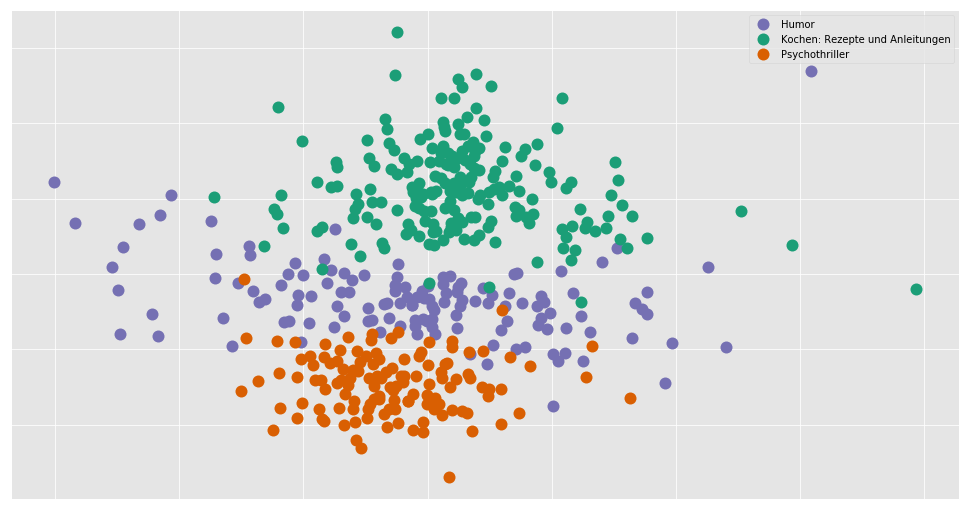

--------Plot generated using data from NMDS---------
name of theme = Humor, code = 2, color_key = #7570b3
name of theme = Kochen: Rezepte und Anleitungen, code = 0, color_key = #1b9e77
name of theme = Psychothriller, code = 1, color_key = #d95f02


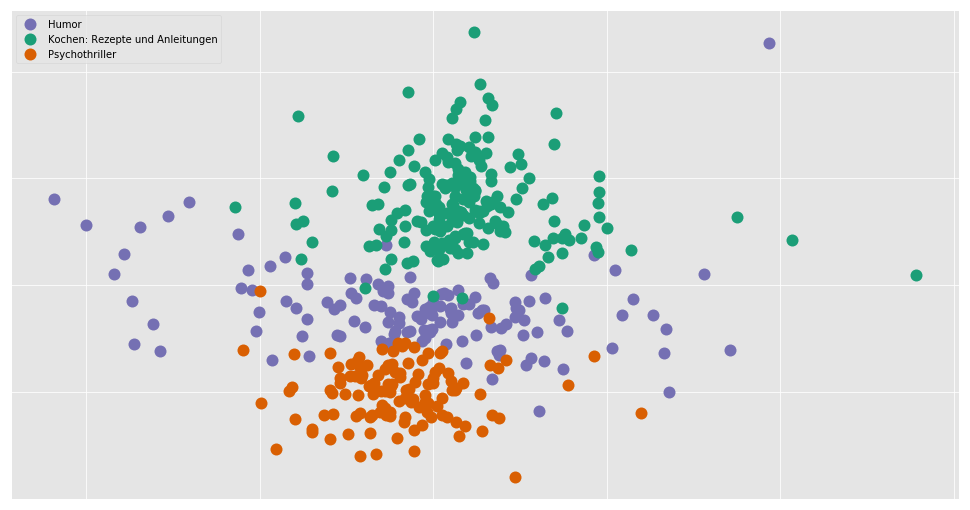

--------Plot generated using data from TSNE---------
name of theme = Humor, code = 2, color_key = #7570b3
name of theme = Kochen: Rezepte und Anleitungen, code = 0, color_key = #1b9e77
name of theme = Psychothriller, code = 1, color_key = #d95f02


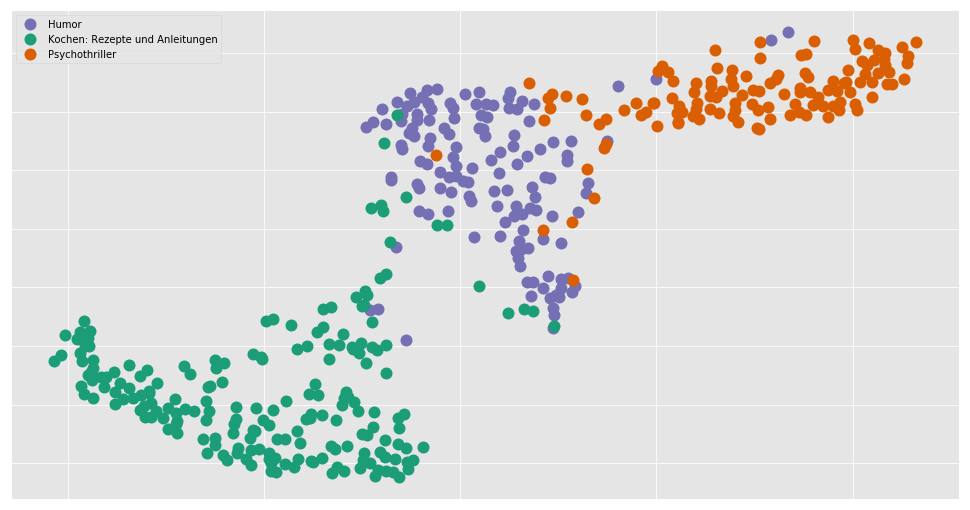

--------Plot generated using data from PCA---------
name of theme = Humor, code = 2, color_key = #7570b3
name of theme = Kochen: Rezepte und Anleitungen, code = 0, color_key = #1b9e77
name of theme = Psychothriller, code = 1, color_key = #d95f02


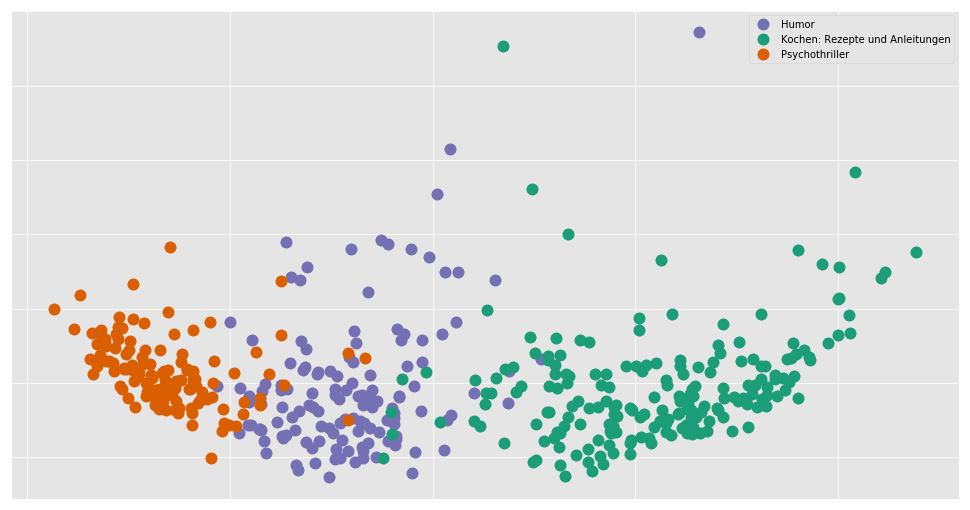

--------Plot generated using data from LLE---------
name of theme = Humor, code = 2, color_key = #7570b3
name of theme = Kochen: Rezepte und Anleitungen, code = 0, color_key = #1b9e77
name of theme = Psychothriller, code = 1, color_key = #d95f02


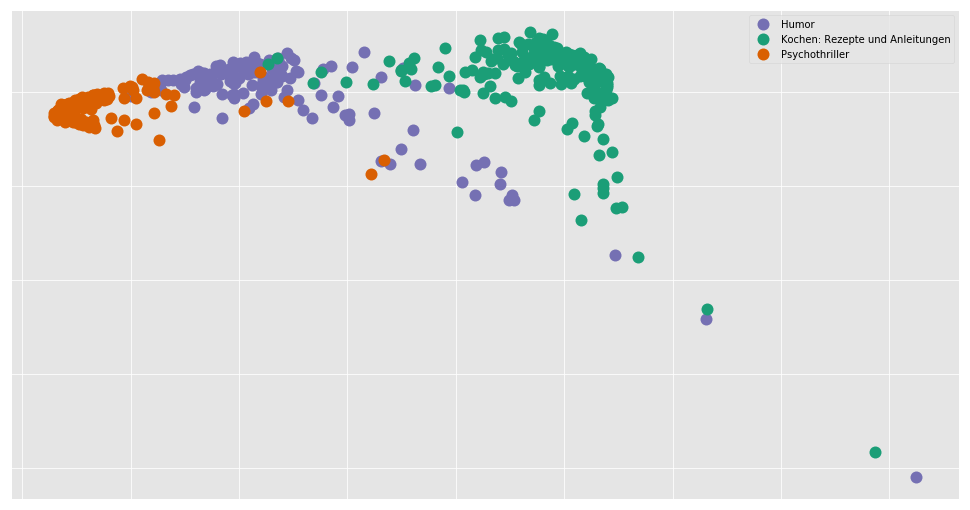

--------Plot generated using data from ISO---------
name of theme = Humor, code = 2, color_key = #7570b3
name of theme = Kochen: Rezepte und Anleitungen, code = 0, color_key = #1b9e77
name of theme = Psychothriller, code = 1, color_key = #d95f02


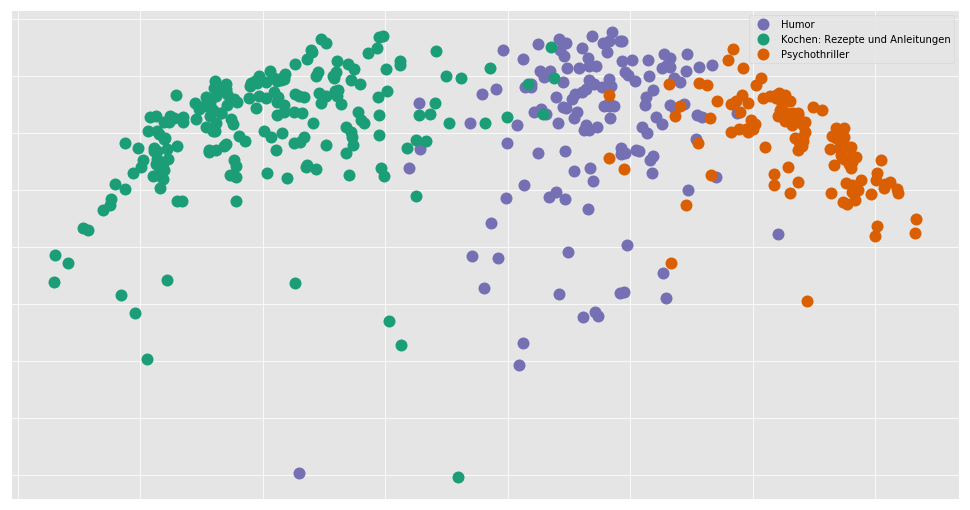

In [78]:
#create data frame that has the result of the MDS and other algorithms for the dimensionality reduction plus the cluster numbers and titles
df_mds = pd.DataFrame(dict(x=xs_mds, y=ys_mds,  theme=train_theme, ID=train_id))
df_pca = pd.DataFrame(dict(x=xs_pca, y=ys_pca, theme=train_theme, ID=train_id ))
df_tsne = pd.DataFrame(dict(x=xs_tsne, y=ys_tsne, theme=train_theme, ID=train_id ))
df_lle = pd.DataFrame(dict(x=xs_lle, y=ys_lle, theme=train_theme, ID=train_id ))
df_iso = pd.DataFrame(dict(x=xs_iso, y=ys_iso, theme=train_theme, ID=train_id ))
df_nmds = pd.DataFrame(dict(x=xs_nmds, y=ys_nmds, theme=train_theme, ID=train_id ))
# define a list of data frames used for dimensionality reduction 
df_name_list = ["MDS","NMDS","TSNE","PCA","LLE","ISO"]
df_list = [df_mds, df_nmds, df_tsne, df_pca, df_lle, df_iso]
for i in range(0,6):
    print "--------Plot generated using data from %s---------" % df_name_list[i]
    plot_data(df_list[i], 'theme', 'sif_exp_'+ df_name_list[i])

### Power Meand Embeddings calculation :

In [77]:
len(texts_lower_de_encoded)
from sklearn.metrics.pairwise import cosine_similarity
sim = cosine_similarity((texts_lower_de_encoded[0]).reshape(1, -1), (texts_lower_de_encoded[1]).reshape(1, -1))[0][0]
print sim
# 10284
# dist_Nosferas3138 = []
# dist_Susewind9651 = []
dist_Selection15366 = []
for i in range(len(texts_lower_de_encoded)):
    sim = cosine_similarity((texts_lower_de_encoded[i]).reshape(1, -1), (texts_lower_de_encoded[15366]).reshape(1, -1))[0][0]
    dist_Selection15366.append(1.0 - sim)

0.9705834


In [78]:
print len(dist_Selection15366)
sorted_dist = np.argsort(dist_Selection15366)

print sorted_dist[:20]
for d in sorted_dist[:15]:
    print train_title[d]
    print train_text[d]
    print

# [10284   777  6184 22218 24558 22308  7189  9939  8422  5750 16927  9601
#  11262 22992  6374 14396  5639 21056 10727   850]

# [ 3138 15015 18916 22134 20875 11028 13900 11337 13255  3074 24197  6293
#   1986 15884 16689 11280 24242 21996 12005 14929]
# [ 9651  6982  6386  8856 20912 25428  7976  6164  7291  4802 15123 22296
#   8853  5256 19882 10606  3866 24153 21102 19628]

26575
[15366 14738 10483 22152 19178 21824 16049 10649 25983 13448  4024  9601
 22498 16830 17557  4702 22222 10969 13959 21176]
Die Falle
Sie stellt ihm eine Falle. Aber ist er wirklich ein Mörder?<br></br><br /></br>Die berühmte Bestsellerautorin Linda Conrads lebt sehr zurückgezogen. Seit elf Jahren hat sie ihr Haus nicht mehr verlassen. Als sie im Fernsehen den Mann zu erkennen glaubt, der vor Jahren ihre Schwester umgebracht hat, versucht sie, ihm eine Falle zu stellen &amp;#8211; Köder ist sie selbst.<br></br><br /></br>Dass sie darüber hinaus eine schreckliche Erinnerung aus der Vergangenheit quält, wissen nur wenige. Vor vielen Jahren hat Linda ihre jüngere Schwester Anna in einem Blutbad vorgefunden &amp;#8211; und den Mörder flüchten sehen. Das Gesicht des Mörders verfolgt sie bis in ihre Träume. Deshalb ist es ein ungeheurer Schock für sie, als sie genau dieses Gesicht eines Tages über ihren Fernseher flimmern sieht. Grund genug für Linda, einen perfiden Plan zu schmieden - 